# Poisson 2d
---

Consider the 2d Poisson Equation
\begin{equation}
\begin{aligned}
&\nabla \cdot (\sigma \nabla u) = f, \\
&\sigma \frac{\partial u}{\partial n}|_{\partial\Omega} = g, \\
\end{aligned}
\end{equation}
where the domain $\Omega = [0, 1]\times [0, 1]$, and the target field $\sigma(x, y) = 0.1\sin(\pi x) + 1.0$.
$f, g$ are chosen such that the exact solution is
\begin{equation}
u(x, y) = \exp(\pi y)\sin(\pi x).
\end{equation}

$f(x, y) = 0.1\pi^2\exp(\pi y)\cos^2(\pi x)$.

For the inverse problem, Dirichlet measurements are provided on the boundary.

We further assume the form of $\sigma$ is known, i.e.
\begin{equation}
\sigma(x, y) = a_2\sin(a_1 x) + a_0),
\end{equation}
and only invert $a_0, a_1, a_2$.

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("./"))))

import torch
import torch.nn as nn
import numpy as np

from pinn_lightning.pinn import PINN, InversePINN, Task
from pinn_lightning.data.dataset import PINNDataModule
from pinn_lightning.data.utils import tensor_grid, tensors_from_numpy
from pinn_lightning.utils.basic_nets import *
from pinn_lightning.utils.operators import grad, directional_grad

import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config Completer.use_jedi = False

import random
torch.manual_seed(1001)
np.random.seed(1001)
random.seed(1001)

torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

# Step 1: Define Model

In [2]:
class Poisson2d(InversePINN):	
	@property
	def pi(self):
		return torch.tensor(np.pi).to(self.device)
	
	def _sigma(self, x):
		return 0.1*torch.sin(self.pi*x) + 1.0
	
	def get_output(self, batch_input):
		(x_domain, y_domain), (x_n, y_n, normal), (x_d, y_d) = batch_input  # x_n: neumann BC; x_d: dirichlet measurements
		x_domain.requires_grad = True
		y_domain.requires_grad = True
		u_domain = self.forward(torch.hstack([x_domain, y_domain]))
		sigma_domain = self.inverse_module(torch.hstack([x_domain, y_domain]))
		
		eq = grad(grad(u_domain, x_domain)*sigma_domain, x_domain) + \
			grad(grad(u_domain, y_domain)*sigma_domain, y_domain) - \
			0.1*self.pi**2*torch.exp(self.pi*y_domain)*torch.cos(self.pi*x_domain)**2
		
		x_n.requires_grad = True
		y_n.requires_grad = True
		u_n = self.forward(torch.hstack([x_n, y_n]))
		u_grad = directional_grad(u_n, x_n, y_n, direction=normal)
		sigma_n = self.inverse_module(torch.hstack([x_n, y_n]))
		sigma = self._sigma(x_n)
		
		u_d = self.forward(torch.hstack([x_d, y_d]))
		return eq, u_grad*sigma, sigma_n-sigma, u_d
	
class SigmaModule(nn.Module):
	def __init__(self, a0, a1, a2):
		super().__init__()
		self.a0 = nn.Parameter(a0)
		self.a1 = nn.Parameter(a1)
		self.a2 = nn.Parameter(a2)
		
	def forward(self, xy):
		return self.a2*torch.sin(self.a1*xy[:, 0:1]) + self.a0
	
class PrintCallback(pl.callbacks.Callback):
	def on_train_batch_end(self, trainer, pl_module, *args, **kwargs):
		pl_module.log("a0", pl_module.inverse_module.a0, on_step=False, on_epoch=True)
		pl_module.log("a1", pl_module.inverse_module.a1, on_step=False, on_epoch=True)
		pl_module.log("a2", pl_module.inverse_module.a2, on_step=False, on_epoch=True)
	
forward_module = DenseNet(
	[2] + [256]*6 + [1], Swish,
)
inverse_module = SigmaModule(
	a0 = torch.tensor(0.0),
	a1 = torch.tensor(1.0),
	a2 = torch.tensor(1.0),
)

pinn = Poisson2d(forward_module, inverse_module)
pinn.configure_tasks(
	[
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 1.0,
			names = "domain",
		),
		Task(
			n_input = 3,
			n_output = 2,
			loss_fns = nn.MSELoss(),
			loss_weights = 10.0,
			names = "neumann",
		),
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 10.0,
			names = "dirichlet",
		),
	]
)
optimizer = torch.optim.Adam(
	[
		{
			"params": pinn.param_groups[0],
			"lr": 1e-3,
			"weight_decay": 0
		},
		{
			"params": pinn.param_groups[1],
			"lr": 1e-3,
			"weight_decay": 0,
		},
	]
)
pinn.configure_optimizers_and_schedulers(
	optimizer = optimizer,
	lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
		optimizer,
		factor = 0.8,
		patience = 100,
		threshold = 1e-6,
		min_lr = 1e-4,
	),
)
pinn

Poisson2d(
  (forward_module): DenseNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): Swish()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Swish()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): Swish()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): Swish()
      (8): Linear(in_features=256, out_features=256, bias=True)
      (9): Swish()
      (10): Linear(in_features=256, out_features=256, bias=True)
      (11): Swish()
      (12): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (inverse_module): SigmaModule()
)

# Step 2: Generate Dataset

In [3]:
x_1d = np.linspace(0, 1, 101).reshape((-1, 1))
y_1d = np.linspace(0, 1, 99).reshape((-1, 1))
xy = tensor_grid([x_1d, y_1d])
x_domain, y_domain = xy[:, 0:1], xy[:, 1:2]
u_domain = np.zeros_like(x_domain)

x_bc_1d = np.linspace(0, 1, 1001).reshape((-1, 1))
y_bc_1d = np.linspace(0, 1, 999).reshape((-1, 1))
xy_bc = np.vstack(
	[
		np.hstack([x_bc_1d, 0*np.ones_like(x_bc_1d)]),
		np.hstack([np.ones_like(y_bc_1d), y_bc_1d]),
		np.hstack([x_bc_1d, np.ones_like(x_bc_1d)]),
		np.hstack([0*np.ones_like(y_bc_1d), y_bc_1d]),
	]
)
normal = np.vstack(
	[
		np.hstack([np.zeros_like(x_bc_1d), -1*np.ones_like(x_bc_1d)]),
		np.hstack([np.ones_like(y_bc_1d), np.zeros_like(y_bc_1d)]),
		np.hstack([np.zeros_like(x_bc_1d), np.ones_like(x_bc_1d)]),
		np.hstack([-np.ones_like(y_bc_1d), np.zeros_like(y_bc_1d)]),
	]
)
x_d, y_d = xy_bc[:, 0:1], xy_bc[:, 1:2]
u_fn = lambda x, y: np.exp(np.pi*y)*np.sin(np.pi*x)
u_d = u_fn(x_d, y_d)

x_n, y_n = x_d, y_d
du_dx_fn = lambda x, y: np.pi*np.exp(np.pi*y)*np.cos(np.pi*x)
du_dy_fn = lambda x, y: np.pi*np.exp(np.pi*y)*np.sin(np.pi*x)
sigma_fn = lambda x, y: 1.0 + 0.1*np.sin(np.pi*x)
sigma_n = sigma_fn(x_n, y_n)
u_n = (du_dx_fn(x_n, y_n)*normal[:, 0:1] + du_dy_fn(x_n, y_n)*normal[:, 1:2])*sigma_n
sigma_n_target = np.zeros_like(sigma_n)

In [4]:
dataset_domain = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_domain, y_domain, u_domain),
)
dataset_n = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_n, y_n, normal, u_n, sigma_n_target),
)
dataset_d = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_d, y_d, u_d),
)

poisson_data_module = PINNDataModule(
	datasets = [dataset_domain, dataset_n, dataset_d],
	collate_fns = [None, None, None],
	valid_splits = [0.2, 0.2, 0.2],
	batch_sizes = [40000, 4000, 4000],
	shuffle = [True, True, True],
)

# Step 3: training

In [ ]:
trainer = pl.Trainer(
	max_epochs=20000,
	gpus=1,
	logger=True,
	callbacks=[
		pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10000),
        pl.callbacks.ModelCheckpoint(dirpath="models", save_last=True, save_top_k=1),
		pl.callbacks.LearningRateMonitor(logging_interval='step'),
		PrintCallback(),
	],
	log_every_n_steps=10,
)
trainer.fit(
	pinn,
	poisson_data_module,
)

In [ ]:
trainer = pl.Trainer(
	max_epochs=30000,
	gpus=1,
	logger=True,
	callbacks=[
		pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10000),
        pl.callbacks.ModelCheckpoint(dirpath="models", save_last=True, save_top_k=1),
		pl.callbacks.LearningRateMonitor(logging_interval='step'),
		PrintCallback(),
	],
	log_every_n_steps=10,
	resume_from_checkpoint = "models/epoch=19999-step=19999-v1.ckpt",
)
trainer.fit(
	pinn,
	poisson_data_module,
)

In [11]:
trainer = pl.Trainer(
	max_epochs=40000,
	gpus=1,
	logger=True,
	callbacks=[
		pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10000),
        pl.callbacks.ModelCheckpoint(dirpath="models", save_last=True, save_top_k=1),
		pl.callbacks.LearningRateMonitor(logging_interval='step'),
		PrintCallback(),
	],
	log_every_n_steps=10,
	resume_from_checkpoint = "models/epoch=29999-step=29999-v1.ckpt",
)
trainer.fit(
	pinn,
	poisson_data_module,
)

/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1905: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit checkpoint path with `trainer.fit(ckpt_path=)` instead.
  rank_zero_deprecation(
/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule

Epoch 30000: : 1it [00:00,  1.36it/s, loss=0.0072, v_num=4]                                   
Validating: 0it [00:00, ?it/s]
Epoch 30000: : 3it [00:00,  3.61it/s, loss=0.0072, v_num=4]
Epoch 30001: : 1it [00:00,  1.46it/s, loss=0.00764, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30001: : 3it [00:00,  3.70it/s, loss=0.00764, v_num=4]
Epoch 30002: : 1it [00:00,  1.47it/s, loss=0.008, v_num=4]  
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30002: : 3it [00:00,  3.72it/s, loss=0.008, v_num=4]
Epoch 30003: : 1it [00:00,  1.43it/s, loss=0.00821, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30003: : 3it [00:00,  3.43it/s, loss=0.00821, v_num=4]
Epoch 30004: : 1it [00:00,  1.62it/s, loss=0.00825, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30004: : 3it [00:00,  3.65it/s, loss=0.00825, v_num=4]
Epoch 30005: : 1it [00:00,  1.62it/s, loss=0.00815, v_num=4]
Validating: 0it [00

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30090: : 3it [00:00,  3.38it/s, loss=0.0114, v_num=4]
Epoch 30091: : 1it [00:00,  1.57it/s, loss=0.011, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30091: : 3it [00:00,  3.54it/s, loss=0.011, v_num=4]
Epoch 30092: : 1it [00:00,  1.58it/s, loss=0.0103, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30092: : 3it [00:00,  3.69it/s, loss=0.0103, v_num=4]
Epoch 30093: : 1it [00:00,  1.65it/s, loss=0.00969, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30093: : 3it [00:00,  3.79it/s, loss=0.00969, v_num=4]
Epoch 30094: : 1it [00:00,  1.60it/s, loss=0.00925, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30094: : 3it [00:00,  3.64it/s, loss=0.00925, v_num=4]
Epoch 30095: : 1it [00:00,  1.43it/s, loss=0.00906, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30095: : 3it [00:00,  3.74it/s, loss=0.00906, v_n

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30181: : 3it [00:00,  3.56it/s, loss=0.0102, v_num=4]
Epoch 30182: : 1it [00:00,  1.39it/s, loss=0.00977, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30182: : 3it [00:00,  3.66it/s, loss=0.00977, v_num=4]
Epoch 30183: : 1it [00:00,  1.46it/s, loss=0.00956, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30183: : 3it [00:00,  3.68it/s, loss=0.00956, v_num=4]
Epoch 30184: : 1it [00:00,  1.41it/s, loss=0.00946, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30184: : 3it [00:00,  3.63it/s, loss=0.00946, v_num=4]
Epoch 30185: : 1it [00:00,  1.46it/s, loss=0.00935, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30185: : 3it [00:00,  3.81it/s, loss=0.00935, v_num=4]
Epoch 30186: : 1it [00:00,  1.45it/s, loss=0.00913, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30186: : 3it [00:00,  3.79it/s, loss=0.00913, v_num=4]
Epoch 30187: : 1it [00:00,  1.38it/s, loss=0.00881,

Validating: 0it [00:00, ?it/s]
Epoch 30271: : 3it [00:00,  3.56it/s, loss=0.0222, v_num=4]
Epoch 30272: : 1it [00:00,  1.45it/s, loss=0.0294, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30272: : 3it [00:00,  3.79it/s, loss=0.0294, v_num=4]
Epoch 30273: : 1it [00:00,  1.44it/s, loss=0.0392, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30273: : 3it [00:00,  3.75it/s, loss=0.0392, v_num=4]
Epoch 30274: : 1it [00:00,  1.44it/s, loss=0.0523, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30274: : 3it [00:00,  3.66it/s, loss=0.0523, v_num=4]
Epoch 30275: : 1it [00:00,  1.41it/s, loss=0.0685, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30275: : 3it [00:00,  3.63it/s, loss=0.0685, v_num=4]
Epoch 30276: : 1it [00:00,  1.41it/s, loss=0.0875, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30276: : 3it [00:00,  3.63it/s, loss=0.0875, v_num=4]
Epoch 30277: : 1it [00:00,  1.41it/s, loss=0.107, v_num=4] 
V

Epoch 30362: : 3it [00:00,  3.53it/s, loss=0.00639, v_num=4]
Epoch 30363: : 1it [00:00,  1.40it/s, loss=0.00644, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30363: : 3it [00:00,  3.58it/s, loss=0.00644, v_num=4]
Epoch 30364: : 1it [00:00,  1.40it/s, loss=0.00651, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30364: : 3it [00:00,  3.69it/s, loss=0.00651, v_num=4]
Epoch 30365: : 1it [00:00,  1.43it/s, loss=0.00661, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30365: : 3it [00:00,  3.63it/s, loss=0.00661, v_num=4]
Epoch 30366: : 1it [00:00,  1.42it/s, loss=0.00675, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30366: : 3it [00:00,  3.72it/s, loss=0.00675, v_num=4]
Epoch 30367: : 1it [00:00,  1.45it/s, loss=0.00696, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30367: : 3it [00:00,  3.69it/s, loss=0.00696, v_num=4]
Epoch 30368: : 1it [00:00,  1.46it/s, loss=0.00727, v_num=4]
Validating: 0it [00:

Epoch 30453: : 3it [00:00,  3.62it/s, loss=0.00632, v_num=4]
Epoch 30454: : 1it [00:00,  1.41it/s, loss=0.00633, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30454: : 3it [00:00,  3.69it/s, loss=0.00633, v_num=4]
Epoch 30454: : 3it [00:00,  3.65it/s, loss=0.00633, v_num=4]
Epoch 30455: : 1it [00:00,  1.38it/s, loss=0.00634, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30455: : 3it [00:00,  3.53it/s, loss=0.00634, v_num=4]
Epoch 30456: : 1it [00:00,  1.45it/s, loss=0.00635, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30456: : 3it [00:00,  3.70it/s, loss=0.00635, v_num=4]
Epoch 30457: : 1it [00:00,  1.34it/s, loss=0.00636, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30457: : 3it [00:00,  3.35it/s, loss=0.00636, v_num=4]
Epoch 30458: : 1it [00:00,  1.37it/s, loss=0.00636, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30458: : 3it [00:00,  3.50it/s, loss=0.00636

Epoch 30545: : 3it [00:00,  3.69it/s, loss=0.00703, v_num=4]
Epoch 30546: : 1it [00:00,  1.45it/s, loss=0.00691, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30546: : 3it [00:00,  3.76it/s, loss=0.00691, v_num=4]
Epoch 30547: : 1it [00:00,  1.42it/s, loss=0.00677, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30547: : 3it [00:00,  3.73it/s, loss=0.00677, v_num=4]
Epoch 30548: : 1it [00:00,  1.40it/s, loss=0.00663, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30548: : 3it [00:00,  3.67it/s, loss=0.00663, v_num=4]
Epoch 30549: : 1it [00:00,  1.40it/s, loss=0.00653, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30549: : 3it [00:00,  3.59it/s, loss=0.00653, v_num=4]
Epoch 30550: : 1it [00:00,  1.42it/s, loss=0.00646, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30550: : 3it [00:00,  3.61it/s, loss=0.00646, v_num=4]
Epoch 30551: : 1it [00:00,  1.44it/s, loss=0.00644, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:

Epoch 30638: : 1it [00:00,  1.43it/s, loss=0.0629, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30638: : 3it [00:00,  3.58it/s, loss=0.0629, v_num=4]
Epoch 30639: : 1it [00:00,  1.44it/s, loss=0.0675, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30639: : 3it [00:00,  3.69it/s, loss=0.0675, v_num=4]
Epoch 30640: : 1it [00:00,  1.45it/s, loss=0.0728, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30640: : 3it [00:00,  3.72it/s, loss=0.0728, v_num=4]
Epoch 30641: : 1it [00:00,  1.45it/s, loss=0.0776, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30641: : 3it [00:00,  3.41it/s, loss=0.0776, v_num=4]
Epoch 30642: : 1it [00:00,  1.63it/s, loss=0.0807, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30642: : 3it [00:00,  3.80it/s, loss=0.0807, v_num=4]
Epoch 30643: : 1it [00:00,  1.64it/s, loss=0.0818, v_num=4]
Validating: 0it [00:00, ?it/s]

Epoch 30729: : 3it [00:00,  3.73it/s, loss=0.0939, v_num=4]
Epoch 30730: : 1it [00:00,  1.59it/s, loss=0.0912, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30730: : 3it [00:00,  3.61it/s, loss=0.0912, v_num=4]
Epoch 30731: : 1it [00:00,  1.59it/s, loss=0.0869, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30731: : 3it [00:00,  3.60it/s, loss=0.0869, v_num=4]
Epoch 30732: : 1it [00:00,  1.61it/s, loss=0.0808, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30732: : 3it [00:00,  3.71it/s, loss=0.0808, v_num=4]
Epoch 30733: : 1it [00:00,  1.40it/s, loss=0.0732, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30733: : 3it [00:00,  3.56it/s, loss=0.0732, v_num=4]
Epoch 30734: : 1it [00:00,  1.46it/s, loss=0.0645, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30734: : 3it [00:00,  3.65it/s, loss=0.0645, v_num=4]
Epoch 30735: : 1it [00:00,  1.

Epoch 30820: : 3it [00:00,  3.67it/s, loss=0.117, v_num=4]
Epoch 30821: : 1it [00:00,  1.42it/s, loss=0.118, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30821: : 3it [00:00,  3.69it/s, loss=0.118, v_num=4]
Epoch 30822: : 1it [00:00,  1.46it/s, loss=0.118, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30822: : 3it [00:00,  3.72it/s, loss=0.118, v_num=4]
Epoch 30823: : 1it [00:00,  1.45it/s, loss=0.118, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30823: : 3it [00:00,  3.71it/s, loss=0.118, v_num=4]
Epoch 30824: : 1it [00:00,  1.35it/s, loss=0.119, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30824: : 3it [00:00,  3.55it/s, loss=0.119, v_num=4]
Epoch 30824: : 3it [00:00,  3.53it/s, loss=0.119, v_num=4]
Epoch 30825: : 1it [00:00,  1.43it/s, loss=0.122, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30825: : 3it [00:00,  3.66it/s, loss=0.122, v_num=4]
Epoch 30826: : 1it [00:00,  1.45it/s, loss=0

Epoch 30913: : 3it [00:00,  3.60it/s, loss=0.025, v_num=4]
Epoch 30914: : 1it [00:00,  1.46it/s, loss=0.0253, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30914: : 3it [00:00,  3.72it/s, loss=0.0253, v_num=4]
Epoch 30915: : 1it [00:00,  1.42it/s, loss=0.0252, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30915: : 3it [00:00,  3.64it/s, loss=0.0252, v_num=4]
Epoch 30916: : 1it [00:00,  1.43it/s, loss=0.0239, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30916: : 3it [00:00,  3.71it/s, loss=0.0239, v_num=4]
Epoch 30917: : 1it [00:00,  1.47it/s, loss=0.0214, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30917: : 3it [00:00,  3.81it/s, loss=0.0214, v_num=4]
Epoch 30917: : 3it [00:00,  3.78it/s, loss=0.0214, v_num=4]
Epoch 30918: : 1it [00:00,  1.40it/s, loss=0.0185, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 30918: : 3it [00:00,  3.60it/s, loss=0.0185, v_num=4]
Epoch 30919: : 1it [00:00,  1.42i

Epoch 31006: : 1it [00:00,  1.40it/s, loss=0.294, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31006: : 3it [00:00,  3.59it/s, loss=0.294, v_num=4]
Epoch 31007: : 1it [00:00,  1.39it/s, loss=0.281, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31007: : 3it [00:00,  3.59it/s, loss=0.281, v_num=4]
Epoch 31008: : 1it [00:00,  1.40it/s, loss=0.26, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31008: : 3it [00:00,  3.58it/s, loss=0.26, v_num=4]
Epoch 31009: : 1it [00:00,  1.45it/s, loss=0.226, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31009: : 3it [00:00,  3.67it/s, loss=0.226, v_num=4]
Epoch 31010: : 1it [00:00,  1.41it/s, loss=0.184, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31010: : 3it [00:00,  3.71it/s, loss=0.184, v_num=4]
Epoch 31011: : 1it [00:00,  1.36it/s, loss=0.143, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31011: : 3it [00:00,  3.57it/s, loss

Epoch 31098: : 1it [00:00,  1.45it/s, loss=0.00558, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31098: : 3it [00:00,  3.78it/s, loss=0.00558, v_num=4]
Epoch 31099: : 1it [00:00,  1.42it/s, loss=0.00558, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31099: : 3it [00:00,  3.63it/s, loss=0.00558, v_num=4]
Epoch 31100: : 1it [00:00,  1.42it/s, loss=0.00557, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31100: : 3it [00:00,  3.65it/s, loss=0.00557, v_num=4]
Epoch 31101: : 1it [00:00,  1.40it/s, loss=0.00557, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31101: : 3it [00:00,  3.50it/s, loss=0.00557, v_num=4]
Epoch 31102: : 1it [00:00,  1.46it/s, loss=0.00557, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31102: : 3it [00:00,  3.83it/s, loss=0.00557, v_num=4]
Epoch 31103: : 1it [00:00,  1.39it/s, loss=0.00557, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31103: : 3it 

Epoch 31189: : 1it [00:00,  1.44it/s, loss=0.0954, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31189: : 3it [00:00,  3.75it/s, loss=0.0954, v_num=4]
Epoch 31190: : 1it [00:00,  1.44it/s, loss=0.0764, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31190: : 3it [00:00,  3.66it/s, loss=0.0764, v_num=4]
Epoch 31191: : 1it [00:00,  1.44it/s, loss=0.0608, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31191: : 3it [00:00,  3.68it/s, loss=0.0608, v_num=4]
Epoch 31192: : 1it [00:00,  1.45it/s, loss=0.0529, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31192: : 3it [00:00,  3.43it/s, loss=0.0529, v_num=4]
Epoch 31193: : 1it [00:00,  1.64it/s, loss=0.0521, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31193: : 3it [00:00,  3.71it/s, loss=0.0521, v_num=4]
Epoch 31194: : 1it [00:00,  1.64it/s, loss=0.0529, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]
Epoch 31279: : 3it [00:00,  3.33it/s, loss=0.00724, v_num=4]
Epoch 31280: : 1it [00:00,  1.59it/s, loss=0.0081, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31280: : 3it [00:00,  3.70it/s, loss=0.0081, v_num=4]
Epoch 31281: : 1it [00:00,  1.55it/s, loss=0.00939, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31281: : 3it [00:00,  3.66it/s, loss=0.00939, v_num=4]
Epoch 31282: : 1it [00:00,  1.55it/s, loss=0.0114, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31282: : 3it [00:00,  3.56it/s, loss=0.0114, v_num=4]
Epoch 31283: : 1it [00:00,  1.55it/s, loss=0.0143, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31283: : 3it [00:00,  3.65it/s, loss=0.0143, v_num=4]
Epoch 31284: : 1it [00:00,  1.46it/s, loss=0.0188, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31284: : 3it [00:00,  3.82it/s, loss=0.0188, v_num=4]
Epoch 31285: : 1it [00:00

Epoch 31369: : 1it [00:00,  1.60it/s, loss=0.00556, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31369: : 3it [00:00,  3.63it/s, loss=0.00556, v_num=4]
Epoch 31370: : 1it [00:00,  1.52it/s, loss=0.00556, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31370: : 3it [00:00,  3.54it/s, loss=0.00556, v_num=4]
Epoch 31371: : 1it [00:00,  1.43it/s, loss=0.00556, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31371: : 3it [00:00,  3.75it/s, loss=0.00556, v_num=4]
Epoch 31372: : 1it [00:00,  1.44it/s, loss=0.00556, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31372: : 3it [00:00,  3.68it/s, loss=0.00556, v_num=4]
Epoch 31373: : 1it [00:00,  1.46it/s, loss=0.00555, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31373: : 3it [00:00,  3.83it/s, loss=0.00555, v_num=4]
Epoch 31374: : 1it [00:00,  1.46it/s, loss=0.00552, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31374: : 3it [00:00,  3.82it/s, loss=0.00552

Epoch 31460: : 3it [00:00,  3.55it/s, loss=0.00531, v_num=4]
Epoch 31461: : 1it [00:00,  1.46it/s, loss=0.00531, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31461: : 3it [00:00,  3.72it/s, loss=0.00531, v_num=4]
Epoch 31462: : 1it [00:00,  1.37it/s, loss=0.00532, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31462: : 3it [00:00,  3.48it/s, loss=0.00532, v_num=4]
Epoch 31463: : 1it [00:00,  1.45it/s, loss=0.00532, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31463: : 3it [00:00,  3.68it/s, loss=0.00532, v_num=4]
Epoch 31464: : 1it [00:00,  1.45it/s, loss=0.00534, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31464: : 3it [00:00,  3.66it/s, loss=0.00534, v_num=4]
Epoch 31465: : 1it [00:00,  1.42it/s, loss=0.00535, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31465: : 3it [00:00,  3.72it/s, loss=0.00535, v_num=4]
Epoch 31466: : 1it [00:00,  1.43it/s, loss=0.00538

Epoch 31552: : 1it [00:00,  1.41it/s, loss=0.00601, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31552: : 3it [00:00,  3.67it/s, loss=0.00601, v_num=4]
Epoch 31553: : 1it [00:00,  1.40it/s, loss=0.00594, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31553: : 3it [00:00,  3.59it/s, loss=0.00594, v_num=4]
Epoch 31554: : 1it [00:00,  1.42it/s, loss=0.00594, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31554: : 3it [00:00,  3.67it/s, loss=0.00594, v_num=4]
Epoch 31555: : 1it [00:00,  1.44it/s, loss=0.00593, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31555: : 3it [00:00,  3.76it/s, loss=0.00593, v_num=4]
Epoch 31556: : 1it [00:00,  1.45it/s, loss=0.00586, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31556: : 3it [00:00,  3.78it/s, loss=0.00586, v_num=4]
Epoch 31557: : 1it [00:00,  1.47it/s, loss=0.00576, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31557: : 3it [00:00,  3.81it/s, loss=0.00576, v_num=4]
Epoch 31558: : 1it [

Validating: 0it [00:00, ?it/s]
Epoch 31645: : 3it [00:00,  3.58it/s, loss=0.00586, v_num=4]
Epoch 31646: : 1it [00:00,  1.42it/s, loss=0.00576, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31646: : 3it [00:00,  3.63it/s, loss=0.00576, v_num=4]
Epoch 31647: : 1it [00:00,  1.41it/s, loss=0.00567, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31647: : 3it [00:00,  3.62it/s, loss=0.00567, v_num=4]
Epoch 31648: : 1it [00:00,  1.42it/s, loss=0.00561, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31648: : 3it [00:00,  3.59it/s, loss=0.00561, v_num=4]
Epoch 31649: : 1it [00:00,  1.38it/s, loss=0.00559, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31649: : 3it [00:00,  3.64it/s, loss=0.00559, v_num=4]
Epoch 31650: : 1it [00:00,  1.44it/s, loss=0.00558, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31650: : 3it [00:00,  3.68it/s, loss=0.00558, v_num=4]
Epoch 31651: : 1it 

Epoch 31736: : 1it [00:00,  1.45it/s, loss=0.0087, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 31736: : 3it [00:00,  3.79it/s, loss=0.0087, v_num=4]
Epoch 31737: : 1it [00:00,  1.41it/s, loss=0.0107, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31737: : 3it [00:00,  3.59it/s, loss=0.0107, v_num=4]
Epoch 31738: : 1it [00:00,  1.45it/s, loss=0.014, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 31738: : 3it [00:00,  3.79it/s, loss=0.014, v_num=4]
Epoch 31739: : 1it [00:00,  1.42it/s, loss=0.0191, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31739: : 3it [00:00,  3.62it/s, loss=0.0191, v_num=4]
Epoch 31740: : 1it [00:00,  1.42it/s, loss=0.0271, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31740: : 3it [00:00,  3.72it/s, loss=0.0271, v_num=4]
Epoch 31741: : 1it [00:00,  1.47it/s, loss=0.0391, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31741: : 3it [00:00,  3.75it/s, loss=0.0391, v_num=4]
E

Epoch 31828: : 3it [00:00,  3.76it/s, loss=0.00522, v_num=4]
Epoch 31829: : 1it [00:00,  1.46it/s, loss=0.00522, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31829: : 3it [00:00,  3.70it/s, loss=0.00522, v_num=4]
Epoch 31830: : 1it [00:00,  1.46it/s, loss=0.00522, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31830: : 3it [00:00,  3.38it/s, loss=0.00522, v_num=4]
Epoch 31831: : 1it [00:00,  1.63it/s, loss=0.0052, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31831: : 3it [00:00,  3.69it/s, loss=0.0052, v_num=4]
Epoch 31832: : 1it [00:00,  1.63it/s, loss=0.00517, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31832: : 3it [00:00,  3.76it/s, loss=0.00517, v_num=4]
Epoch 31833: : 1it [00:00,  1.63it/s, loss=0.00515, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31833: : 3it [00:00,  3.78it/s, loss=0.00515, v_num=4]
Epoch 31834: : 1it [

Epoch 31920: : 1it [00:00,  1.62it/s, loss=0.00621, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31920: : 3it [00:00,  3.65it/s, loss=0.00621, v_num=4]
Epoch 31921: : 1it [00:00,  1.58it/s, loss=0.00607, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31921: : 3it [00:00,  3.65it/s, loss=0.00607, v_num=4]
Epoch 31922: : 1it [00:00,  1.42it/s, loss=0.00588, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31922: : 3it [00:00,  3.63it/s, loss=0.00588, v_num=4]
Epoch 31923: : 1it [00:00,  1.46it/s, loss=0.00572, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 31923: : 3it [00:00,  3.74it/s, loss=0.00572, v_num=4]
Epoch 31924: : 1it [00:00,  1.42it/s, loss=0.00561, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31924: : 3it [00:00,  3.71it/s, loss=0.00561, v_num=4]
Epoch 31925: : 1it [00:00,  1.44it/s, loss=0.00555, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00

Validating: 0it [00:00, ?it/s]
Epoch 32011: : 3it [00:00,  3.63it/s, loss=0.0251, v_num=4]
Epoch 32012: : 1it [00:00,  1.46it/s, loss=0.0243, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32012: : 3it [00:00,  3.80it/s, loss=0.0243, v_num=4]
Epoch 32013: : 1it [00:00,  1.38it/s, loss=0.0232, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32013: : 3it [00:00,  3.64it/s, loss=0.0232, v_num=4]
Epoch 32014: : 1it [00:00,  1.38it/s, loss=0.0214, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32014: : 3it [00:00,  3.56it/s, loss=0.0214, v_num=4]
Epoch 32015: : 1it [00:00,  1.46it/s, loss=0.0191, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32015: : 3it [00:00,  3.76it/s, loss=0.0191, v_num=4]
Epoch 32016: : 1it [00:00,  1.39it/s, loss=0.017, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32016: : 3it [00:00,  3.54it/s, loss=0.017, v_num=4]
Epoch 32017: : 1it [00:00,  1.39it/s, loss=0.0157, v_num=4]
Va

Epoch 32102: : 1it [00:00,  1.39it/s, loss=0.0591, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32102: : 3it [00:00,  3.66it/s, loss=0.0591, v_num=4]
Epoch 32103: : 1it [00:00,  1.46it/s, loss=0.0771, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32103: : 3it [00:00,  3.78it/s, loss=0.0771, v_num=4]
Epoch 32104: : 1it [00:00,  1.45it/s, loss=0.0962, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32104: : 3it [00:00,  3.66it/s, loss=0.0962, v_num=4]
Epoch 32105: : 1it [00:00,  1.46it/s, loss=0.114, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32105: : 3it [00:00,  3.72it/s, loss=0.114, v_num=4]
Epoch 32106: : 1it [00:00,  1.42it/s, loss=0.128, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32106: : 3it [00:00,  3.69it/s, loss=0.128, v_num=4]
Epoch 32107: : 1it [00:00,  1.42it/s, loss=0.136, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32107: : 3it [00:00,  3.71it/s, loss=0.136, v_num=4]
Epoch 32108: : 1it [00:00,  1.38it/s,

Epoch 32193: : 1it [00:00,  1.42it/s, loss=0.0049, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32193: : 3it [00:00,  3.63it/s, loss=0.0049, v_num=4]
Epoch 32194: : 1it [00:00,  1.36it/s, loss=0.00489, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32194: : 3it [00:00,  3.59it/s, loss=0.00489, v_num=4]
Epoch 32195: : 1it [00:00,  1.45it/s, loss=0.00489, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32195: : 3it [00:00,  3.67it/s, loss=0.00489, v_num=4]
Epoch 32196: : 1it [00:00,  1.42it/s, loss=0.00489, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32196: : 3it [00:00,  3.61it/s, loss=0.00489, v_num=4]
Epoch 32197: : 1it [00:00,  1.42it/s, loss=0.00489, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32197: : 3it [00:00,  3.65it/s, loss=0.00489, v_num=4]
Epoch 32198: : 1it [00:00,  1.41it/s, loss=0.00489, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:

Epoch 32283: : 3it [00:00,  3.70it/s, loss=0.00697, v_num=4]
Epoch 32284: : 1it [00:00,  1.44it/s, loss=0.00662, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32284: : 3it [00:00,  3.65it/s, loss=0.00662, v_num=4]
Epoch 32285: : 1it [00:00,  1.36it/s, loss=0.00631, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32285: : 3it [00:00,  3.51it/s, loss=0.00631, v_num=4]
Epoch 32286: : 1it [00:00,  1.41it/s, loss=0.00613, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32286: : 3it [00:00,  3.66it/s, loss=0.00613, v_num=4]
Epoch 32287: : 1it [00:00,  1.45it/s, loss=0.00606, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32287: : 3it [00:00,  3.68it/s, loss=0.00606, v_num=4]
Epoch 32288: : 1it [00:00,  1.40it/s, loss=0.00603, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32288: : 3it [00:00,  3.57it/s, loss=0.00603, v_num=4]
Epoch 32289: : 1it [00:00,  1.41it/s, loss=0.00597

Validating: 0it [00:00, ?it/s]
Epoch 32329: : 3it [00:00,  3.55it/s, loss=0.00484, v_num=4]
Epoch 32330: : 1it [00:00,  1.39it/s, loss=0.00485, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32330: : 3it [00:00,  3.67it/s, loss=0.00485, v_num=4]
Epoch 32331: : 1it [00:00,  1.39it/s, loss=0.00486, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32331: : 3it [00:00,  3.56it/s, loss=0.00486, v_num=4]
Epoch 32332: : 1it [00:00,  1.39it/s, loss=0.00488, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32332: : 3it [00:00,  3.66it/s, loss=0.00488, v_num=4]
Epoch 32333: : 1it [00:00,  1.37it/s, loss=0.0049, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 32333: : 3it [00:00,  3.63it/s, loss=0.0049, v_num=4]
Epoch 32334: : 1it [00:00,  1.41it/s, loss=0.00493, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32334: : 3it [00:00,  3.57it/s, loss=0.00493, v_num=4]
Epoch 32335: : 1it [00:00,  1.39it/s, loss=0.00497, v_num=4]
Validating: 0it [00:0

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32422: : 3it [00:00,  3.60it/s, loss=0.00522, v_num=4]
Epoch 32423: : 1it [00:00,  1.38it/s, loss=0.00523, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32423: : 3it [00:00,  3.55it/s, loss=0.00523, v_num=4]
Epoch 32424: : 1it [00:00,  1.41it/s, loss=0.00523, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32424: : 3it [00:00,  3.59it/s, loss=0.00523, v_num=4]
Epoch 32425: : 1it [00:00,  1.43it/s, loss=0.0052, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 32425: : 3it [00:00,  3.74it/s, loss=0.0052, v_num=4]
Epoch 32426: : 1it [00:00,  1.39it/s, loss=0.00513, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32426: : 3it [00:00,  3.64it/s, loss=0.00513, v_num=4]
Epoch 32427: : 1it [00:00,  1.35it/s, loss=0.00506, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32427: : 3it [00:00,  3.51it/s, loss=0.00506, v_num=4]
Epoch 32428: : 1it [00:00,  1.38it/s, loss=0.00499,

Validating: 0it [00:00, ?it/s]
Epoch 32514: : 3it [00:00,  3.69it/s, loss=0.0633, v_num=4]
Epoch 32515: : 1it [00:00,  1.40it/s, loss=0.0565, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32515: : 3it [00:00,  3.67it/s, loss=0.0565, v_num=4]
Epoch 32516: : 1it [00:00,  1.45it/s, loss=0.0509, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32516: : 3it [00:00,  3.67it/s, loss=0.0509, v_num=4]
Epoch 32517: : 1it [00:00,  1.40it/s, loss=0.0468, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32517: : 3it [00:00,  3.69it/s, loss=0.0468, v_num=4]
Epoch 32518: : 1it [00:00,  1.39it/s, loss=0.0429, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32518: : 3it [00:00,  3.59it/s, loss=0.0429, v_num=4]
Epoch 32519: : 1it [00:00,  1.40it/s, loss=0.0386, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32519: : 3it [00:00,  3.67it/s, loss=0.0386, v_num=4]
Epoch 32520: : 1it [00:00,  1.43it/s, loss=0.0342, v_num=4]
Validating: 0it [00:00, ?it/s]
E

Epoch 32606: : 1it [00:00,  1.41it/s, loss=0.0046, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32606: : 3it [00:00,  3.70it/s, loss=0.0046, v_num=4]
Epoch 32607: : 1it [00:00,  1.41it/s, loss=0.0046, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32607: : 3it [00:00,  3.71it/s, loss=0.0046, v_num=4]
Epoch 32608: : 1it [00:00,  1.42it/s, loss=0.0046, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32608: : 3it [00:00,  3.61it/s, loss=0.0046, v_num=4]
Epoch 32609: : 1it [00:00,  1.40it/s, loss=0.0046, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32609: : 3it [00:00,  3.56it/s, loss=0.0046, v_num=4]
Epoch 32610: : 1it [00:00,  1.39it/s, loss=0.00461, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32610: : 3it [00:00,  3.65it/s, loss=0.00461, v_num=4]
Epoch 32611: : 1it [00:00,  1.37it/s, loss=0.00461, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32611: : 3it [00:00,  3.61it/s, loss=0.00461, v_num=4]
Epoch 32612: : 1it [00:00,  

Epoch 32698: : 3it [00:00,  3.62it/s, loss=0.00572, v_num=4]
Epoch 32699: : 1it [00:00,  1.46it/s, loss=0.00563, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32699: : 3it [00:00,  3.71it/s, loss=0.00563, v_num=4]
Epoch 32700: : 1it [00:00,  1.46it/s, loss=0.00562, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32700: : 3it [00:00,  3.39it/s, loss=0.00562, v_num=4]
Epoch 32701: : 1it [00:00,  1.64it/s, loss=0.00559, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32701: : 3it [00:00,  3.67it/s, loss=0.00559, v_num=4]
Epoch 32702: : 1it [00:00,  1.58it/s, loss=0.0055, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32702: : 3it [00:00,  3.61it/s, loss=0.0055, v_num=4]
Epoch 32703: : 1it [00:00,  1.64it/s, loss=0.00536, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32703: : 3it [00:00,  3.67it/s, loss=0.00536, v_num=4]
Epoch 32704: : 1it [

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32790: : 3it [00:00,  3.61it/s, loss=0.00451, v_num=4]
Epoch 32791: : 1it [00:00,  1.65it/s, loss=0.00452, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32791: : 3it [00:00,  3.75it/s, loss=0.00452, v_num=4]
Epoch 32792: : 1it [00:00,  1.39it/s, loss=0.00453, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32792: : 3it [00:00,  3.57it/s, loss=0.00453, v_num=4]
Epoch 32793: : 1it [00:00,  1.43it/s, loss=0.00455, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32793: : 3it [00:00,  3.74it/s, loss=0.00455, v_num=4]
Epoch 32794: : 1it [00:00,  1.46it/s, loss=0.00458, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32794: : 3it [00:00,  3.72it/s, loss=0.00458, v_num=4]
Epoch 32795: : 1it [00:00,  1.43it/s, loss=0.00463, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32795: : 3it [00:00,  3.74it/s, loss=0.00463, v_num=4]
Epoch 32796: : 1it 

Validating: 0it [00:00, ?it/s]
Epoch 32881: : 3it [00:00,  3.64it/s, loss=0.00506, v_num=4]
Epoch 32882: : 1it [00:00,  1.40it/s, loss=0.00498, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32882: : 3it [00:00,  3.59it/s, loss=0.00498, v_num=4]
Epoch 32883: : 1it [00:00,  1.42it/s, loss=0.00488, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32883: : 3it [00:00,  3.63it/s, loss=0.00488, v_num=4]
Epoch 32884: : 1it [00:00,  1.39it/s, loss=0.00482, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32884: : 3it [00:00,  3.66it/s, loss=0.00482, v_num=4]
Epoch 32885: : 1it [00:00,  1.39it/s, loss=0.00479, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32885: : 3it [00:00,  3.64it/s, loss=0.00479, v_num=4]
Epoch 32886: : 1it [00:00,  1.41it/s, loss=0.00479, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32886: : 3it [00:00,  3.68it/s, loss=0.00479, v_num=4]
Epoch 32887: : 1it [00:00,  1.45it/s, loss=0.00478, v_num=4]
Validating: 0it [00:

Epoch 32974: : 1it [00:00,  1.41it/s, loss=0.00563, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32974: : 3it [00:00,  3.60it/s, loss=0.00563, v_num=4]
Epoch 32975: : 1it [00:00,  1.38it/s, loss=0.00563, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32975: : 3it [00:00,  3.56it/s, loss=0.00563, v_num=4]
Epoch 32976: : 1it [00:00,  1.46it/s, loss=0.00559, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32976: : 3it [00:00,  3.72it/s, loss=0.00559, v_num=4]
Epoch 32977: : 1it [00:00,  1.42it/s, loss=0.0055, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 32977: : 3it [00:00,  3.74it/s, loss=0.0055, v_num=4]
Epoch 32978: : 1it [00:00,  1.42it/s, loss=0.00536, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 32978: : 3it [00:00,  3.54it/s, loss=0.00536, v_num=4]
Epoch 32979: : 1it [00:00,  1.37it/s, loss=0.0052, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:

Epoch 33063: : 3it [00:00,  3.66it/s, loss=0.157, v_num=4]
Epoch 33064: : 1it [00:00,  1.39it/s, loss=0.158, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33064: : 3it [00:00,  3.59it/s, loss=0.158, v_num=4]
Epoch 33065: : 1it [00:00,  1.41it/s, loss=0.158, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33065: : 3it [00:00,  3.70it/s, loss=0.158, v_num=4]
Epoch 33066: : 1it [00:00,  1.44it/s, loss=0.16, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33066: : 3it [00:00,  3.65it/s, loss=0.16, v_num=4]
Epoch 33067: : 1it [00:00,  1.39it/s, loss=0.166, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33067: : 3it [00:00,  3.58it/s, loss=0.166, v_num=4]
Epoch 33068: : 1it [00:00,  1.41it/s, loss=0.175, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33068: : 3it [00:00,  3.69it/s, loss=0.175, v_num=4]
Epoch 33069: : 1it [00:00,  1.44it/s, loss=0.182, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0i

Epoch 33155: : 1it [00:00,  1.33it/s, loss=0.00436, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33155: : 3it [00:00,  3.46it/s, loss=0.00436, v_num=4]
Epoch 33156: : 1it [00:00,  1.42it/s, loss=0.00435, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33156: : 3it [00:00,  3.61it/s, loss=0.00435, v_num=4]
Epoch 33157: : 1it [00:00,  1.38it/s, loss=0.00435, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33157: : 3it [00:00,  3.53it/s, loss=0.00435, v_num=4]
Epoch 33158: : 1it [00:00,  1.45it/s, loss=0.00435, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33158: : 3it [00:00,  3.65it/s, loss=0.00435, v_num=4]
Epoch 33159: : 1it [00:00,  1.39it/s, loss=0.00435, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33159: : 3it [00:00,  3.51it/s, loss=0.00435, v_num=4]
Epoch 33160: : 1it [00:00,  1.44it/s, loss=0.00436, v_num=4]
Validating: 0it [00

Epoch 33246: : 1it [00:00,  1.36it/s, loss=0.00463, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33246: : 3it [00:00,  3.58it/s, loss=0.00463, v_num=4]
Epoch 33247: : 1it [00:00,  1.41it/s, loss=0.00457, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33247: : 3it [00:00,  3.60it/s, loss=0.00457, v_num=4]
Epoch 33248: : 1it [00:00,  1.42it/s, loss=0.00454, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33248: : 3it [00:00,  3.61it/s, loss=0.00454, v_num=4]
Epoch 33249: : 1it [00:00,  1.43it/s, loss=0.00455, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33249: : 3it [00:00,  3.66it/s, loss=0.00455, v_num=4]
Epoch 33250: : 1it [00:00,  1.44it/s, loss=0.00455, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33250: : 3it [00:00,  3.70it/s, loss=0.00455, v_num=4]
Epoch 33251: : 1it [00:00,  1.40it/s, loss=0.00454, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00

Epoch 33337: : 3it [00:00,  3.74it/s, loss=0.00518, v_num=4]
Epoch 33338: : 1it [00:00,  1.46it/s, loss=0.00519, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33338: : 3it [00:00,  3.38it/s, loss=0.00519, v_num=4]
Epoch 33339: : 1it [00:00,  1.54it/s, loss=0.00515, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33339: : 3it [00:00,  3.59it/s, loss=0.00515, v_num=4]
Epoch 33340: : 1it [00:00,  1.59it/s, loss=0.00505, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33340: : 3it [00:00,  3.64it/s, loss=0.00505, v_num=4]
Epoch 33341: : 1it [00:00,  1.58it/s, loss=0.00492, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33341: : 3it [00:00,  3.59it/s, loss=0.00492, v_num=4]
Epoch 33342: : 1it [00:00,  1.50it/s, loss=0.00479, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33342: : 3it [00:00,  3.51it/s, loss=0.00479, v_num=4]
Epoch 33343: : 1it 

Epoch 33430: : 3it [00:00,  3.55it/s, loss=0.0392, v_num=4]
Epoch 33430: : 3it [00:00,  3.51it/s, loss=0.0392, v_num=4]
Epoch 33431: : 1it [00:00,  1.43it/s, loss=0.0549, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33431: : 3it [00:00,  3.61it/s, loss=0.0549, v_num=4]
Epoch 33432: : 1it [00:00,  1.46it/s, loss=0.0736, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33432: : 3it [00:00,  3.81it/s, loss=0.0736, v_num=4]
Epoch 33433: : 1it [00:00,  1.41it/s, loss=0.0913, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33433: : 3it [00:00,  3.56it/s, loss=0.0913, v_num=4]
Epoch 33434: : 1it [00:00,  1.43it/s, loss=0.104, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 33434: : 3it [00:00,  3.72it/s, loss=0.104, v_num=4]
Epoch 33435: : 1it [00:00,  1.41it/s, loss=0.111, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33435: : 3it [00:00,  3.61it/s, loss=0.111, v_num=4]
Epoch 33436: : 1it [00:00,  1.43it/

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33522: : 3it [00:00,  3.57it/s, loss=0.019, v_num=4]
Epoch 33523: : 1it [00:00,  1.41it/s, loss=0.0193, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33523: : 3it [00:00,  3.62it/s, loss=0.0193, v_num=4]
Epoch 33524: : 1it [00:00,  1.41it/s, loss=0.0191, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33524: : 3it [00:00,  3.62it/s, loss=0.0191, v_num=4]
Epoch 33525: : 1it [00:00,  1.39it/s, loss=0.0183, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33525: : 3it [00:00,  3.57it/s, loss=0.0183, v_num=4]
Epoch 33526: : 1it [00:00,  1.37it/s, loss=0.0168, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33526: : 3it [00:00,  3.60it/s, loss=0.0168, v_num=4]
Epoch 33527: : 1it [00:00,  1.45it/s, loss=0.015, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33527: : 3it [00:00,  3.67it/s, loss=0.015, v_num=4]
E

Validating: 0it [00:00, ?it/s]
Epoch 33614: : 3it [00:00,  3.55it/s, loss=0.0406, v_num=4]
Epoch 33615: : 1it [00:00,  1.34it/s, loss=0.0365, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33615: : 3it [00:00,  3.43it/s, loss=0.0365, v_num=4]
Epoch 33616: : 1it [00:00,  1.32it/s, loss=0.0306, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33616: : 3it [00:00,  3.48it/s, loss=0.0306, v_num=4]
Epoch 33617: : 1it [00:00,  1.32it/s, loss=0.0251, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33617: : 3it [00:00,  3.44it/s, loss=0.0251, v_num=4]
Epoch 33618: : 1it [00:00,  1.28it/s, loss=0.0213, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33618: : 3it [00:00,  3.33it/s, loss=0.0213, v_num=4]
Epoch 33619: : 1it [00:01,  1.15s/it, loss=0.0199, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33619: : 3it [00:01,  2.36it/s, loss=0.0199, v_num=4]
Epoch 33620: : 1it [00:00,  1.

Epoch 33705: : 3it [00:00,  3.56it/s, loss=0.00404, v_num=4]
Epoch 33706: : 1it [00:00,  1.37it/s, loss=0.00404, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33706: : 3it [00:00,  3.59it/s, loss=0.00404, v_num=4]
Epoch 33707: : 1it [00:00,  1.37it/s, loss=0.00405, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33707: : 3it [00:00,  3.52it/s, loss=0.00405, v_num=4]
Epoch 33708: : 1it [00:00,  1.38it/s, loss=0.00405, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33708: : 3it [00:00,  3.63it/s, loss=0.00405, v_num=4]
Epoch 33709: : 1it [00:00,  1.45it/s, loss=0.00406, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33709: : 3it [00:00,  3.71it/s, loss=0.00406, v_num=4]
Epoch 33710: : 1it [00:00,  1.43it/s, loss=0.00407, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33710: : 3it [00:00,  3.73it/s, loss=0.00407, v_num=4]
Epoch 33711: : 1it [00:00,  1.38it/s, loss=0.00408, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33711: : 3it [

Epoch 33795: : 3it [00:00,  3.68it/s, loss=0.00538, v_num=4]
Epoch 33796: : 1it [00:00,  1.39it/s, loss=0.00533, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33796: : 3it [00:00,  3.56it/s, loss=0.00533, v_num=4]
Epoch 33797: : 1it [00:00,  1.33it/s, loss=0.00519, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33797: : 3it [00:00,  3.54it/s, loss=0.00519, v_num=4]
Epoch 33798: : 1it [00:00,  1.36it/s, loss=0.00499, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33798: : 3it [00:00,  3.51it/s, loss=0.00499, v_num=4]
Epoch 33799: : 1it [00:00,  1.45it/s, loss=0.0048, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 33799: : 3it [00:00,  3.78it/s, loss=0.0048, v_num=4]
Epoch 33799: : 3it [00:00,  3.75it/s, loss=0.0048, v_num=4]
Epoch 33800: : 1it [00:00,  1.41it/s, loss=0.00468, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33800: : 3it [00:00,  3.61it/s, loss=0.00468, v_num=4]
Epoch 33801: : 1it [00

Validating: 0it [00:00, ?it/s]
Epoch 33886: : 3it [00:00,  3.71it/s, loss=0.0045, v_num=4]
Epoch 33887: : 1it [00:00,  1.44it/s, loss=0.0045, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33887: : 3it [00:00,  3.77it/s, loss=0.0045, v_num=4]
Epoch 33888: : 1it [00:00,  1.44it/s, loss=0.00448, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33888: : 3it [00:00,  3.77it/s, loss=0.00448, v_num=4]
Epoch 33889: : 1it [00:00,  1.42it/s, loss=0.00443, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33889: : 3it [00:00,  3.37it/s, loss=0.00443, v_num=4]
Epoch 33890: : 1it [00:00,  1.62it/s, loss=0.00436, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33890: : 3it [00:00,  3.67it/s, loss=0.00436, v_num=4]
Epoch 33891: : 1it [00:00,  1.63it/s, loss=0.00429, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33891: : 3it [00:00,  3.77it/s, loss=0.00429, v_num=4]
Epoch 33892: : 1it [00:00,  1.58it/s, loss=0.00423, v

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33980: : 3it [00:00,  3.71it/s, loss=0.00873, v_num=4]
Epoch 33981: : 1it [00:00,  1.39it/s, loss=0.00875, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33981: : 3it [00:00,  3.65it/s, loss=0.00875, v_num=4]
Epoch 33982: : 1it [00:00,  1.41it/s, loss=0.00846, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33982: : 3it [00:00,  3.65it/s, loss=0.00846, v_num=4]
Epoch 33983: : 1it [00:00,  1.39it/s, loss=0.00783, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 33983: : 3it [00:00,  3.59it/s, loss=0.00783, v_num=4]
Epoch 33984: : 1it [00:00,  1.42it/s, loss=0.00707, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33984: : 3it [00:00,  3.72it/s, loss=0.00707, v_num=4]
Epoch 33985: : 1it [00:00,  1.39it/s, loss=0.00647, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33985: : 3it [00:00,  3.66it/s, loss=0.00647, v_num=4]
Epoch 33986: : 1it [00:00,  1.45it/s, loss=0.00618

Validating: 0it [00:00, ?it/s]
Epoch 34073: : 3it [00:00,  3.68it/s, loss=0.0468, v_num=4]
Epoch 34074: : 1it [00:00,  1.43it/s, loss=0.0385, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34074: : 3it [00:00,  3.65it/s, loss=0.0385, v_num=4]
Epoch 34075: : 1it [00:00,  1.39it/s, loss=0.0336, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34075: : 3it [00:00,  3.52it/s, loss=0.0336, v_num=4]
Epoch 34076: : 1it [00:00,  1.40it/s, loss=0.032, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 34076: : 3it [00:00,  3.66it/s, loss=0.032, v_num=4]
Epoch 34077: : 1it [00:00,  1.37it/s, loss=0.0318, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34077: : 3it [00:00,  3.51it/s, loss=0.0318, v_num=4]
Epoch 34078: : 1it [00:00,  1.37it/s, loss=0.0311, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34078: : 3it [00:00,  3.53it/s, loss=0.0311, v_num=4]
Epoch 34079: : 1it [00:00,  1.3

Validating: 0it [00:00, ?it/s]
Epoch 34166: : 3it [00:00,  3.58it/s, loss=0.0166, v_num=4]
Epoch 34167: : 1it [00:00,  1.43it/s, loss=0.0166, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34167: : 3it [00:00,  3.76it/s, loss=0.0166, v_num=4]
Epoch 34168: : 1it [00:00,  1.39it/s, loss=0.0159, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34168: : 3it [00:00,  3.67it/s, loss=0.0159, v_num=4]
Epoch 34169: : 1it [00:00,  1.43it/s, loss=0.0143, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34169: : 3it [00:00,  3.74it/s, loss=0.0143, v_num=4]
Epoch 34170: : 1it [00:00,  1.36it/s, loss=0.0124, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34170: : 3it [00:00,  3.48it/s, loss=0.0124, v_num=4]
Epoch 34171: : 1it [00:00,  1.43it/s, loss=0.0109, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34171: : 3it [00:00,  3.74it/s, loss=0.0109, v_num=4]
Epoch 34172: : 1it [00:00,  1.38it/s, loss=0.0103, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
E

Epoch 34257: : 1it [00:00,  1.40it/s, loss=0.00377, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34257: : 3it [00:00,  3.65it/s, loss=0.00377, v_num=4]
Epoch 34258: : 1it [00:00,  1.43it/s, loss=0.00377, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34258: : 3it [00:00,  3.64it/s, loss=0.00377, v_num=4]
Epoch 34259: : 1it [00:00,  1.44it/s, loss=0.00377, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34259: : 3it [00:00,  3.64it/s, loss=0.00377, v_num=4]
Epoch 34260: : 1it [00:00,  1.38it/s, loss=0.00377, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34260: : 3it [00:00,  3.58it/s, loss=0.00377, v_num=4]
Epoch 34261: : 1it [00:00,  1.38it/s, loss=0.00377, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34261: : 3it [00:00,  3.63it/s, loss=0.00377, v_num=4]
Epoch 34262: : 1it [00:00,  1.44it/s, loss=0.00377, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34262: : 3it [00:00,  3.75it/s, loss=0.00377

Validating: 0it [00:00, ?it/s]
Epoch 34350: : 3it [00:00,  3.83it/s, loss=0.00721, v_num=4]
Epoch 34351: : 1it [00:00,  1.43it/s, loss=0.00709, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34351: : 3it [00:00,  3.76it/s, loss=0.00709, v_num=4]
Epoch 34352: : 1it [00:00,  1.45it/s, loss=0.00685, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34352: : 3it [00:00,  3.77it/s, loss=0.00685, v_num=4]
Epoch 34353: : 1it [00:00,  1.47it/s, loss=0.00647, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34353: : 3it [00:00,  3.48it/s, loss=0.00647, v_num=4]
Epoch 34354: : 1it [00:00,  1.57it/s, loss=0.00606, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34354: : 3it [00:00,  3.56it/s, loss=0.00606, v_num=4]
Epoch 34355: : 1it [00:00,  1.58it/s, loss=0.00572, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34355: : 3it [00:00,  3.65it/s, loss=0.00572, v_num=4]
Epoch 34356: : 1it [00:00,  1.54it/s, loss=0.00545

Epoch 34444: : 1it [00:00,  1.64it/s, loss=0.00619, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34444: : 3it [00:00,  3.79it/s, loss=0.00619, v_num=4]
Epoch 34445: : 1it [00:00,  1.46it/s, loss=0.00577, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34445: : 3it [00:00,  3.80it/s, loss=0.00577, v_num=4]
Epoch 34446: : 1it [00:00,  1.44it/s, loss=0.00535, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34446: : 3it [00:00,  3.69it/s, loss=0.00535, v_num=4]
Epoch 34447: : 1it [00:00,  1.45it/s, loss=0.00506, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34447: : 3it [00:00,  3.73it/s, loss=0.00506, v_num=4]
Epoch 34448: : 1it [00:00,  1.42it/s, loss=0.00496, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34448: : 3it [00:00,  3.63it/s, loss=0.00496, v_num=4]
Epoch 34449: : 1it [00:00,  1.46it/s, loss=0.00498, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00

Epoch 34535: : 1it [00:00,  1.44it/s, loss=0.057, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 34535: : 3it [00:00,  3.78it/s, loss=0.057, v_num=4]
Epoch 34536: : 1it [00:00,  1.45it/s, loss=0.0716, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34536: : 3it [00:00,  3.69it/s, loss=0.0716, v_num=4]
Epoch 34537: : 1it [00:00,  1.37it/s, loss=0.0838, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34537: : 3it [00:00,  3.51it/s, loss=0.0838, v_num=4]
Epoch 34538: : 1it [00:00,  1.45it/s, loss=0.0908, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34538: : 3it [00:00,  3.79it/s, loss=0.0908, v_num=4]
Epoch 34539: : 1it [00:00,  1.37it/s, loss=0.0932, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34539: : 3it [00:00,  3.52it/s, loss=0.0932, v_num=4]
Epoch 34540: : 1it [00:00,  1.45it/s, loss=0.0936, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34540: : 3it [00:00,  3.76it/s, loss=0.0936, v_num=4]
Ep

Epoch 34582: : 3it [00:00,  3.73it/s, loss=0.0103, v_num=4]
Epoch 34583: : 1it [00:00,  1.46it/s, loss=0.0105, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34583: : 3it [00:00,  3.77it/s, loss=0.0105, v_num=4]
Epoch 34584: : 1it [00:00,  1.40it/s, loss=0.0112, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34584: : 3it [00:00,  3.60it/s, loss=0.0112, v_num=4]
Epoch 34585: : 1it [00:00,  1.47it/s, loss=0.0125, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34585: : 3it [00:00,  3.39it/s, loss=0.0125, v_num=4]
Epoch 34586: : 1it [00:00,  1.60it/s, loss=0.014, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34586: : 3it [00:00,  3.53it/s, loss=0.014, v_num=4]
Epoch 34587: : 1it [00:00,  1.58it/s, loss=0.0157, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34587: : 3it [00:00,  3.66it/s, loss=0.0157, v_num=4]
Epoch 34588: : 1it [00:00,  1.6

Epoch 34675: : 1it [00:00,  1.59it/s, loss=0.00392, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34675: : 3it [00:00,  3.68it/s, loss=0.00392, v_num=4]
Epoch 34676: : 1it [00:00,  1.59it/s, loss=0.00389, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34676: : 3it [00:00,  3.65it/s, loss=0.00389, v_num=4]
Epoch 34677: : 1it [00:00,  1.38it/s, loss=0.00385, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34677: : 3it [00:00,  3.62it/s, loss=0.00385, v_num=4]
Epoch 34678: : 1it [00:00,  1.38it/s, loss=0.00382, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34678: : 3it [00:00,  3.63it/s, loss=0.00382, v_num=4]
Epoch 34679: : 1it [00:00,  1.38it/s, loss=0.00379, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34679: : 3it [00:00,  3.63it/s, loss=0.00379, v_num=4]
Epoch 34680: : 1it [00:00,  1.46it/s, loss=0.00376, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34680: : 3it [00:00,  3.74it/s, loss=0.00376

Epoch 34769: : 1it [00:00,  1.41it/s, loss=0.00493, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34769: : 3it [00:00,  3.60it/s, loss=0.00493, v_num=4]
Epoch 34770: : 1it [00:00,  1.44it/s, loss=0.00496, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34770: : 3it [00:00,  3.67it/s, loss=0.00496, v_num=4]
Epoch 34771: : 1it [00:00,  1.43it/s, loss=0.00498, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34771: : 3it [00:00,  3.65it/s, loss=0.00498, v_num=4]
Epoch 34772: : 1it [00:00,  1.44it/s, loss=0.00491, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34772: : 3it [00:00,  3.67it/s, loss=0.00491, v_num=4]
Epoch 34773: : 1it [00:00,  1.39it/s, loss=0.00473, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34773: : 3it [00:00,  3.64it/s, loss=0.00473, v_num=4]
Epoch 34774: : 1it [00:00,  1.42it/s, loss=0.0045, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 34774: : 3it 

Epoch 34863: : 1it [00:00,  1.41it/s, loss=0.106, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34863: : 3it [00:00,  3.62it/s, loss=0.106, v_num=4]
Epoch 34864: : 1it [00:00,  1.40it/s, loss=0.107, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34864: : 3it [00:00,  3.63it/s, loss=0.107, v_num=4]
Epoch 34865: : 1it [00:00,  1.38it/s, loss=0.106, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34865: : 3it [00:00,  3.63it/s, loss=0.106, v_num=4]
Epoch 34866: : 1it [00:00,  1.37it/s, loss=0.106, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34866: : 3it [00:00,  3.52it/s, loss=0.106, v_num=4]
Epoch 34867: : 1it [00:00,  1.41it/s, loss=0.106, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34867: : 3it [00:00,  3.60it/s, loss=0.106, v_num=4]
Epoch 34868: : 1it [00:00,  1.40it/s, loss=0.107, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34868: : 3it [00:00,  3.66it/s, los

Epoch 34957: : 3it [00:00,  3.61it/s, loss=0.0342, v_num=4]
Epoch 34958: : 1it [00:00,  1.42it/s, loss=0.0341, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34958: : 3it [00:00,  3.63it/s, loss=0.0341, v_num=4]
Epoch 34959: : 1it [00:00,  1.42it/s, loss=0.0322, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34959: : 3it [00:00,  3.71it/s, loss=0.0322, v_num=4]
Epoch 34960: : 1it [00:00,  1.41it/s, loss=0.0281, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34960: : 3it [00:00,  3.68it/s, loss=0.0281, v_num=4]
Epoch 34961: : 1it [00:00,  1.43it/s, loss=0.0236, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34961: : 3it [00:00,  3.62it/s, loss=0.0236, v_num=4]
Epoch 34962: : 1it [00:00,  1.45it/s, loss=0.0204, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 34962: : 3it [00:00,  3.43it/s, loss=0.0204, v_num=4]
Epoch 34963: : 1it [00:00,  1.62it/s, loss=0.0193, v_num=4]
Validating: 0it [00:00, ?it/s]
V

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35051: : 3it [00:00,  3.67it/s, loss=0.00344, v_num=4]
Epoch 35052: : 1it [00:00,  1.59it/s, loss=0.00344, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35052: : 3it [00:00,  3.63it/s, loss=0.00344, v_num=4]
Epoch 35053: : 1it [00:00,  1.64it/s, loss=0.00344, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35053: : 3it [00:00,  3.70it/s, loss=0.00344, v_num=4]
Epoch 35054: : 1it [00:00,  1.41it/s, loss=0.00344, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35054: : 3it [00:00,  3.69it/s, loss=0.00344, v_num=4]
Epoch 35055: : 1it [00:00,  1.45it/s, loss=0.00344, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35055: : 3it [00:00,  3.80it/s, loss=0.00344, v_num=4]
Epoch 35056: : 1it [00:00,  1.38it/s, loss=0.00344, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35056: : 3it [00:00,  3.51it/s, loss=0.00344, v_num=4]
Epoch 35057: : 1it 

Validating: 0it [00:00, ?it/s]
Epoch 35144: : 3it [00:00,  3.74it/s, loss=0.239, v_num=4]
Epoch 35145: : 1it [00:00,  1.43it/s, loss=0.227, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35145: : 3it [00:00,  3.71it/s, loss=0.227, v_num=4]
Epoch 35146: : 1it [00:00,  1.41it/s, loss=0.209, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35146: : 3it [00:00,  3.69it/s, loss=0.209, v_num=4]
Epoch 35147: : 1it [00:00,  1.41it/s, loss=0.186, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35147: : 3it [00:00,  3.70it/s, loss=0.186, v_num=4]
Epoch 35148: : 1it [00:00,  1.43it/s, loss=0.159, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35148: : 3it [00:00,  3.73it/s, loss=0.159, v_num=4]
Epoch 35149: : 1it [00:00,  1.34it/s, loss=0.128, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35149: : 3it [00:00,  3.56it/s, loss=0.128, v_num=4]
Epoch 35150: : 1it [00:00,  1.45it/s, loss=0.102, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35150: : 3it [00:00,  3.79it/s, loss=0

Validating: 0it [00:00, ?it/s]
Epoch 35238: : 3it [00:00,  3.67it/s, loss=0.0844, v_num=4]
Epoch 35239: : 1it [00:00,  1.41it/s, loss=0.0825, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35239: : 3it [00:00,  3.57it/s, loss=0.0825, v_num=4]
Epoch 35240: : 1it [00:00,  1.43it/s, loss=0.0796, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35240: : 3it [00:00,  3.74it/s, loss=0.0796, v_num=4]
Epoch 35241: : 1it [00:00,  1.40it/s, loss=0.075, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35241: : 3it [00:00,  3.60it/s, loss=0.075, v_num=4]
Epoch 35242: : 1it [00:00,  1.40it/s, loss=0.0683, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35242: : 3it [00:00,  3.60it/s, loss=0.0683, v_num=4]
Epoch 35243: : 1it [00:00,  1.41it/s, loss=0.0596, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35243: : 3it [00:00,  3.65it/s, loss=0.0596, v_num=4]
Epoch 35244: : 1it [00:00,  1.4

Epoch 35330: : 1it [00:00,  1.39it/s, loss=0.00335, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35330: : 3it [00:00,  3.65it/s, loss=0.00335, v_num=4]
Epoch 35331: : 1it [00:00,  1.44it/s, loss=0.00335, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35331: : 3it [00:00,  3.78it/s, loss=0.00335, v_num=4]
Epoch 35332: : 1it [00:00,  1.41it/s, loss=0.00335, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35332: : 3it [00:00,  3.59it/s, loss=0.00335, v_num=4]
Epoch 35333: : 1it [00:00,  1.39it/s, loss=0.00335, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35333: : 3it [00:00,  3.67it/s, loss=0.00335, v_num=4]
Epoch 35334: : 1it [00:00,  1.39it/s, loss=0.00335, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35334: : 3it [00:00,  3.64it/s, loss=0.00335, v_num=4]
Epoch 35335: : 1it [00:00,  1.41it/s, loss=0.00335, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35335: : 3it [00:00,  3.73it/s, loss=0.00335, v_num=4]
Epoch 35336: : 1it [00:00,  1.42it/s, loss=0.00335,

Epoch 35424: : 3it [00:00,  3.70it/s, loss=0.00548, v_num=4]
Epoch 35425: : 1it [00:00,  1.44it/s, loss=0.0053, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 35425: : 3it [00:00,  3.77it/s, loss=0.0053, v_num=4]
Epoch 35426: : 1it [00:00,  1.43it/s, loss=0.00503, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35426: : 3it [00:00,  3.40it/s, loss=0.00503, v_num=4]
Epoch 35427: : 1it [00:00,  1.63it/s, loss=0.00476, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35427: : 3it [00:00,  3.65it/s, loss=0.00476, v_num=4]
Epoch 35428: : 1it [00:00,  1.54it/s, loss=0.00459, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35428: : 3it [00:00,  3.57it/s, loss=0.00459, v_num=4]
Epoch 35429: : 1it [00:00,  1.53it/s, loss=0.00454, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35429: : 3it [00:00,  3.52it/s, loss=0.00454, v_num=4]
Epoch 35430: : 1it [00:00,  1.56it/s, loss=0.00453,

Epoch 35517: : 3it [00:00,  3.55it/s, loss=0.0294, v_num=4]
Epoch 35518: : 1it [00:00,  1.42it/s, loss=0.0287, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35518: : 3it [00:00,  3.57it/s, loss=0.0287, v_num=4]
Epoch 35519: : 1it [00:00,  1.43it/s, loss=0.0282, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35519: : 3it [00:00,  3.64it/s, loss=0.0282, v_num=4]
Epoch 35520: : 1it [00:00,  1.44it/s, loss=0.0263, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35520: : 3it [00:00,  3.65it/s, loss=0.0263, v_num=4]
Epoch 35521: : 1it [00:00,  1.42it/s, loss=0.023, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35521: : 3it [00:00,  3.57it/s, loss=0.023, v_num=4]
Epoch 35522: : 1it [00:00,  1.41it/s, loss=0.0196, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35522: : 3it [00:00,  3.72it/s, loss=0.0196, v_num=4]
Epoch 35523: : 1it [00:00,  1.41it/s, loss=0.0173, v_num=4]
Va

Epoch 35611: : 3it [00:00,  3.54it/s, loss=0.00344, v_num=4]
Epoch 35612: : 1it [00:00,  1.40it/s, loss=0.00354, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35612: : 3it [00:00,  3.62it/s, loss=0.00354, v_num=4]
Epoch 35613: : 1it [00:00,  1.45it/s, loss=0.00369, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35613: : 3it [00:00,  3.77it/s, loss=0.00369, v_num=4]
Epoch 35614: : 1it [00:00,  1.43it/s, loss=0.00394, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35614: : 3it [00:00,  3.73it/s, loss=0.00394, v_num=4]
Epoch 35615: : 1it [00:00,  1.43it/s, loss=0.00433, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35615: : 3it [00:00,  3.74it/s, loss=0.00433, v_num=4]
Epoch 35616: : 1it [00:00,  1.43it/s, loss=0.00495, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35616: : 3it [00:00,  3.69it/s, loss=0.00495, v_num=4]
Epoch 35617: : 1it [00:00,  1.44it/s, loss=0.00593, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:

Epoch 35706: : 3it [00:00,  3.71it/s, loss=0.00356, v_num=4]
Epoch 35707: : 1it [00:00,  1.37it/s, loss=0.00356, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35707: : 3it [00:00,  3.60it/s, loss=0.00356, v_num=4]
Epoch 35708: : 1it [00:00,  1.39it/s, loss=0.00358, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35708: : 3it [00:00,  3.64it/s, loss=0.00358, v_num=4]
Epoch 35709: : 1it [00:00,  1.37it/s, loss=0.00361, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35709: : 3it [00:00,  3.50it/s, loss=0.00361, v_num=4]
Epoch 35710: : 1it [00:00,  1.45it/s, loss=0.00365, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35710: : 3it [00:00,  3.78it/s, loss=0.00365, v_num=4]
Epoch 35711: : 1it [00:00,  1.45it/s, loss=0.0037, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35711: : 3it [00:00,  3.69it/s, loss=0.0037, v_num=4]
Epoch 35712: : 1it [00:00,  1.45it/s, loss=0.00376, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35712: : 3it [0

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35801: : 3it [00:00,  3.44it/s, loss=0.00367, v_num=4]
Epoch 35802: : 1it [00:00,  1.64it/s, loss=0.00365, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35802: : 3it [00:00,  3.68it/s, loss=0.00365, v_num=4]
Epoch 35803: : 1it [00:00,  1.57it/s, loss=0.00361, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35803: : 3it [00:00,  3.65it/s, loss=0.00361, v_num=4]
Epoch 35804: : 1it [00:00,  1.59it/s, loss=0.00354, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35804: : 3it [00:00,  3.72it/s, loss=0.00354, v_num=4]
Epoch 35805: : 1it [00:00,  1.64it/s, loss=0.00348, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35805: : 3it [00:00,  3.77it/s, loss=0.00348, v_num=4]
Epoch 35806: : 1it [00:00,  1.39it/s, loss=0.00342, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35806: : 3it [00:00,  3.65it/s, loss=0.0034

Epoch 35894: : 3it [00:00,  3.51it/s, loss=0.0472, v_num=4]
Epoch 35895: : 1it [00:00,  1.45it/s, loss=0.0482, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35895: : 3it [00:00,  3.80it/s, loss=0.0482, v_num=4]
Epoch 35896: : 1it [00:00,  1.44it/s, loss=0.0475, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35896: : 3it [00:00,  3.76it/s, loss=0.0475, v_num=4]
Epoch 35897: : 1it [00:00,  1.39it/s, loss=0.0437, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35897: : 3it [00:00,  3.57it/s, loss=0.0437, v_num=4]
Epoch 35898: : 1it [00:00,  1.41it/s, loss=0.0372, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35898: : 3it [00:00,  3.59it/s, loss=0.0372, v_num=4]
Epoch 35899: : 1it [00:00,  1.45it/s, loss=0.0305, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35899: : 3it [00:00,  3.70it/s, loss=0.0305, v_num=4]
Epoch 35900: : 1it [00:00,  1.45it/s, loss=0.0255, v_num=4]
Validating: 0it [00:00, ?it/s]
V

Epoch 35989: : 3it [00:00,  3.67it/s, loss=0.0305, v_num=4]
Epoch 35990: : 1it [00:00,  1.44it/s, loss=0.0289, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 35990: : 3it [00:00,  3.77it/s, loss=0.0289, v_num=4]
Epoch 35991: : 1it [00:00,  1.41it/s, loss=0.0287, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35991: : 3it [00:00,  3.61it/s, loss=0.0287, v_num=4]
Epoch 35992: : 1it [00:00,  1.39it/s, loss=0.028, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35992: : 3it [00:00,  3.57it/s, loss=0.028, v_num=4]
Epoch 35993: : 1it [00:00,  1.40it/s, loss=0.0261, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 35993: : 3it [00:00,  3.62it/s, loss=0.0261, v_num=4]
Epoch 35994: : 1it [00:00,  1.42it/s, loss=0.023, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 35994: : 3it [00:00,  3.72it/s, loss=0.023, v_num=4]
Epoch 35995: : 1it [00:00,  1.40it/s, loss=0.0197, v_num=4]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 36082: : 3it [00:00,  3.78it/s, loss=0.114, v_num=4]
Epoch 36083: : 1it [00:00,  1.41it/s, loss=0.0917, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36083: : 3it [00:00,  3.63it/s, loss=0.0917, v_num=4]
Epoch 36084: : 1it [00:00,  1.40it/s, loss=0.0731, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36084: : 3it [00:00,  3.60it/s, loss=0.0731, v_num=4]
Epoch 36085: : 1it [00:00,  1.45it/s, loss=0.0605, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36085: : 3it [00:00,  3.79it/s, loss=0.0605, v_num=4]
Epoch 36086: : 1it [00:00,  1.37it/s, loss=0.0551, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36086: : 3it [00:00,  3.59it/s, loss=0.0551, v_num=4]
Epoch 36087: : 1it [00:00,  1.43it/s, loss=0.0543, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36087: : 3it [00:00,  3.76it/s, loss=0.0543, v_num=4]
Epoch 36088: : 1it [00:00,  1.46it/s, loss=0.0545, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Ep

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36174: : 3it [00:00,  3.55it/s, loss=0.00306, v_num=4]
Epoch 36175: : 1it [00:00,  1.37it/s, loss=0.00305, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36175: : 3it [00:00,  3.60it/s, loss=0.00305, v_num=4]
Epoch 36176: : 1it [00:00,  1.46it/s, loss=0.00305, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36176: : 3it [00:00,  3.80it/s, loss=0.00305, v_num=4]
Epoch 36177: : 1it [00:00,  1.39it/s, loss=0.00305, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36177: : 3it [00:00,  3.54it/s, loss=0.00305, v_num=4]
Epoch 36178: : 1it [00:00,  1.46it/s, loss=0.00305, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36178: : 3it [00:00,  3.34it/s, loss=0.00305, v_num=4]
Epoch 36179: : 1it [00:00,  1.57it/s, loss=0.00305, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36179: : 3it [00:00,  3.63it/s, loss=0.00305, v_num=4]
Epoch 36180: : 1it 

Epoch 36267: : 3it [00:00,  3.71it/s, loss=0.00517, v_num=4]
Epoch 36268: : 1it [00:00,  1.56it/s, loss=0.0052, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36268: : 3it [00:00,  3.54it/s, loss=0.0052, v_num=4]
Epoch 36269: : 1it [00:00,  1.58it/s, loss=0.00536, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36269: : 3it [00:00,  3.61it/s, loss=0.00536, v_num=4]
Epoch 36270: : 1it [00:00,  1.39it/s, loss=0.00569, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36270: : 3it [00:00,  3.64it/s, loss=0.00569, v_num=4]
Epoch 36271: : 1it [00:00,  1.37it/s, loss=0.00617, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36271: : 3it [00:00,  3.62it/s, loss=0.00617, v_num=4]
Epoch 36272: : 1it [00:00,  1.38it/s, loss=0.00681, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36272: : 3it [00:00,  3.60it/s, loss=0.00681, v_num=4]
Epoch 36272: : 3it [00:00,  3.57it/s, loss=0.00681, v_num=4]
Epoch 36273: : 1it [00:00,  1.40it/s, loss=0.00776, 

Epoch 36360: : 3it [00:00,  3.70it/s, loss=0.00326, v_num=4]
Epoch 36361: : 1it [00:00,  1.39it/s, loss=0.00324, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36361: : 3it [00:00,  3.66it/s, loss=0.00324, v_num=4]
Epoch 36362: : 1it [00:00,  1.43it/s, loss=0.00321, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36362: : 3it [00:00,  3.67it/s, loss=0.00321, v_num=4]
Epoch 36363: : 1it [00:00,  1.41it/s, loss=0.00318, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36363: : 3it [00:00,  3.60it/s, loss=0.00318, v_num=4]
Epoch 36364: : 1it [00:00,  1.41it/s, loss=0.00314, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36364: : 3it [00:00,  3.59it/s, loss=0.00314, v_num=4]
Epoch 36365: : 1it [00:00,  1.44it/s, loss=0.00311, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36365: : 3it [00:00,  3.68it/s, loss=0.00311, v_num=4]
Epoch 36366: : 1it [00:00,  1.46it/s, loss=0.00309

Epoch 36453: : 3it [00:00,  3.65it/s, loss=0.0568, v_num=4]
Epoch 36454: : 1it [00:00,  1.45it/s, loss=0.0519, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36454: : 3it [00:00,  3.72it/s, loss=0.0519, v_num=4]
Epoch 36455: : 1it [00:00,  1.43it/s, loss=0.0516, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36455: : 3it [00:00,  3.63it/s, loss=0.0516, v_num=4]
Epoch 36456: : 1it [00:00,  1.40it/s, loss=0.0521, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36456: : 3it [00:00,  3.58it/s, loss=0.0521, v_num=4]
Epoch 36457: : 1it [00:00,  1.38it/s, loss=0.0502, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36457: : 3it [00:00,  3.55it/s, loss=0.0502, v_num=4]
Epoch 36458: : 1it [00:00,  1.39it/s, loss=0.0449, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36458: : 3it [00:00,  3.57it/s, loss=0.0449, v_num=4]
Epoch 36459: : 1it [00:00,  1.

Epoch 36548: : 1it [00:00,  1.38it/s, loss=0.0441, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36548: : 3it [00:00,  3.65it/s, loss=0.0441, v_num=4]
Epoch 36549: : 1it [00:00,  1.45it/s, loss=0.0355, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36549: : 3it [00:00,  3.72it/s, loss=0.0355, v_num=4]
Epoch 36550: : 1it [00:00,  1.43it/s, loss=0.0301, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36550: : 3it [00:00,  3.63it/s, loss=0.0301, v_num=4]
Epoch 36551: : 1it [00:00,  1.41it/s, loss=0.0279, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36551: : 3it [00:00,  3.70it/s, loss=0.0279, v_num=4]
Epoch 36552: : 1it [00:00,  1.40it/s, loss=0.0278, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36552: : 3it [00:00,  3.67it/s, loss=0.0278, v_num=4]
Epoch 36553: : 1it [00:00,  1.46it/s, loss=0.0277, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36553: : 3it [00:00,  3.79it/s, loss=0.0277, v_num=4]
Epoch 36554: : 1it [00:00,  1.40

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36642: : 3it [00:00,  3.37it/s, loss=0.173, v_num=4]
Epoch 36643: : 1it [00:00,  1.58it/s, loss=0.17, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36643: : 3it [00:00,  3.64it/s, loss=0.17, v_num=4]
Epoch 36644: : 1it [00:00,  1.63it/s, loss=0.167, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36644: : 3it [00:00,  3.75it/s, loss=0.167, v_num=4]
Epoch 36645: : 1it [00:00,  1.63it/s, loss=0.164, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36645: : 3it [00:00,  3.75it/s, loss=0.164, v_num=4]
Epoch 36646: : 1it [00:00,  1.58it/s, loss=0.159, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36646: : 3it [00:00,  3.61it/s, loss=0.159, v_num=4]
Epoch 36647: : 1it [00:00,  1.45it/s, loss=0.152, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36647: : 3it [00:00,  3.78it/s, loss=0.152, v_num=4]
Epoch 36648

Epoch 36734: : 3it [00:00,  3.58it/s, loss=0.00289, v_num=4]
Epoch 36735: : 1it [00:00,  1.39it/s, loss=0.00288, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36735: : 3it [00:00,  3.67it/s, loss=0.00288, v_num=4]
Epoch 36736: : 1it [00:00,  1.39it/s, loss=0.00288, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36736: : 3it [00:00,  3.56it/s, loss=0.00288, v_num=4]
Epoch 36737: : 1it [00:00,  1.43it/s, loss=0.00288, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36737: : 3it [00:00,  3.60it/s, loss=0.00288, v_num=4]
Epoch 36738: : 1it [00:00,  1.41it/s, loss=0.00288, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36738: : 3it [00:00,  3.66it/s, loss=0.00288, v_num=4]
Epoch 36739: : 1it [00:00,  1.44it/s, loss=0.00288, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36739: : 3it [00:00,  3.68it/s, loss=0.00288, v_num=4]
Epoch 36740: : 1it [00:00,  1.45it/s, loss=0.00288, v_num=4]
Validating: 0it [00:

Epoch 36827: : 1it [00:00,  1.43it/s, loss=0.00561, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36827: : 3it [00:00,  3.62it/s, loss=0.00561, v_num=4]
Epoch 36828: : 1it [00:00,  1.39it/s, loss=0.00572, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36828: : 3it [00:00,  3.64it/s, loss=0.00572, v_num=4]
Epoch 36829: : 1it [00:00,  1.45it/s, loss=0.00616, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36829: : 3it [00:00,  3.69it/s, loss=0.00616, v_num=4]
Epoch 36830: : 1it [00:00,  1.41it/s, loss=0.00678, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36830: : 3it [00:00,  3.61it/s, loss=0.00678, v_num=4]
Epoch 36831: : 1it [00:00,  1.42it/s, loss=0.0075, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 36831: : 3it [00:00,  3.72it/s, loss=0.0075, v_num=4]
Epoch 36832: : 1it [00:00,  1.40it/s, loss=0.00848, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36832: : 3it [00:00,  3.68it/s, loss=0.00848,

Epoch 36922: : 1it [00:00,  1.44it/s, loss=0.003, v_num=4]  
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36922: : 3it [00:00,  3.68it/s, loss=0.003, v_num=4]
Epoch 36923: : 1it [00:00,  1.39it/s, loss=0.00297, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36923: : 3it [00:00,  3.67it/s, loss=0.00297, v_num=4]
Epoch 36924: : 1it [00:00,  1.39it/s, loss=0.00294, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36924: : 3it [00:00,  3.66it/s, loss=0.00294, v_num=4]
Epoch 36925: : 1it [00:00,  1.41it/s, loss=0.00292, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 36925: : 3it [00:00,  3.58it/s, loss=0.00292, v_num=4]
Epoch 36926: : 1it [00:00,  1.41it/s, loss=0.0029, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 36926: : 3it [00:00,  3.68it/s, loss=0.0029, v_num=4]
Epoch 36926: : 3it [00:00,  3.65it/s, loss=0.0029, v_num=4]
Epoch 36927: : 1it [00:00,  1.42it/s, loss=0.0029, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36927: : 3it [00:00

Epoch 37015: : 3it [00:00,  3.66it/s, loss=0.0514, v_num=4]
Epoch 37016: : 1it [00:00,  1.39it/s, loss=0.0473, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37016: : 3it [00:00,  3.58it/s, loss=0.0473, v_num=4]
Epoch 37017: : 1it [00:00,  1.42it/s, loss=0.0404, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37017: : 3it [00:00,  3.70it/s, loss=0.0404, v_num=4]
Epoch 37018: : 1it [00:00,  1.44it/s, loss=0.0332, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37018: : 3it [00:00,  3.67it/s, loss=0.0332, v_num=4]
Epoch 37019: : 1it [00:00,  1.46it/s, loss=0.0278, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37019: : 3it [00:00,  3.42it/s, loss=0.0278, v_num=4]
Epoch 37020: : 1it [00:00,  1.55it/s, loss=0.0255, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37020: : 3it [00:00,  3.54it/s, loss=0.0255, v_num=4]
Epoch 37021: : 1it [00:00,  1.63it/s, loss=0.0253, v_num=4]
V

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37109: : 3it [00:00,  3.70it/s, loss=0.0137, v_num=4]
Epoch 37110: : 1it [00:00,  1.60it/s, loss=0.0183, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37110: : 3it [00:00,  3.64it/s, loss=0.0183, v_num=4]
Epoch 37111: : 1it [00:00,  1.40it/s, loss=0.0243, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37111: : 3it [00:00,  3.58it/s, loss=0.0243, v_num=4]
Epoch 37112: : 1it [00:00,  1.40it/s, loss=0.0314, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37112: : 3it [00:00,  3.69it/s, loss=0.0314, v_num=4]
Epoch 37113: : 1it [00:00,  1.39it/s, loss=0.0393, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37113: : 3it [00:00,  3.55it/s, loss=0.0393, v_num=4]
Epoch 37114: : 1it [00:00,  1.40it/s, loss=0.0468, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37114: : 3it [00:00,  3.67it/s, loss=0.0468, v_num=4]
Epoch 37115: : 1it [00:00,  1.

Epoch 37203: : 1it [00:00,  1.40it/s, loss=0.179, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37203: : 3it [00:00,  3.69it/s, loss=0.179, v_num=4]
Epoch 37204: : 1it [00:00,  1.44it/s, loss=0.171, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37204: : 3it [00:00,  3.77it/s, loss=0.171, v_num=4]
Epoch 37204: : 3it [00:00,  3.74it/s, loss=0.171, v_num=4]
Epoch 37205: : 1it [00:00,  1.40it/s, loss=0.156, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37205: : 3it [00:00,  3.68it/s, loss=0.156, v_num=4]
Epoch 37206: : 1it [00:00,  1.35it/s, loss=0.135, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37206: : 3it [00:00,  3.59it/s, loss=0.135, v_num=4]
Epoch 37207: : 1it [00:00,  1.42it/s, loss=0.112, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37207: : 3it [00:00,  3.58it/s, loss=0.112, v_num=4]
Epoch 37208: : 1it [00:00,  1.41it/s, loss=0.0897, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37208: : 3it [00:00,  3.57it/s, loss=

Epoch 37295: : 3it [00:00,  3.77it/s, loss=0.00272, v_num=4]
Epoch 37296: : 1it [00:00,  1.39it/s, loss=0.00272, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37296: : 3it [00:00,  3.67it/s, loss=0.00272, v_num=4]
Epoch 37297: : 1it [00:00,  1.45it/s, loss=0.00273, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37297: : 3it [00:00,  3.62it/s, loss=0.00273, v_num=4]
Epoch 37298: : 1it [00:00,  1.38it/s, loss=0.00273, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37298: : 3it [00:00,  3.62it/s, loss=0.00273, v_num=4]
Epoch 37299: : 1it [00:00,  1.38it/s, loss=0.00273, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37299: : 3it [00:00,  3.63it/s, loss=0.00273, v_num=4]
Epoch 37300: : 1it [00:00,  1.34it/s, loss=0.00273, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37300: : 3it [00:00,  3.53it/s, loss=0.00273, v_num=4]
Epoch 37301: : 1it [00:00,  1.44it/s, loss=0.00273, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37301: : 3it [

Epoch 37390: : 1it [00:00,  1.42it/s, loss=0.0127, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37390: : 3it [00:00,  3.63it/s, loss=0.0127, v_num=4]
Epoch 37391: : 1it [00:00,  1.39it/s, loss=0.0162, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37391: : 3it [00:00,  3.57it/s, loss=0.0162, v_num=4]
Epoch 37392: : 1it [00:00,  1.37it/s, loss=0.021, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 37392: : 3it [00:00,  3.62it/s, loss=0.021, v_num=4]
Epoch 37393: : 1it [00:00,  1.42it/s, loss=0.0275, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37393: : 3it [00:00,  3.65it/s, loss=0.0275, v_num=4]
Epoch 37394: : 1it [00:00,  1.41it/s, loss=0.0361, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37394: : 3it [00:00,  3.68it/s, loss=0.0361, v_num=4]
Epoch 37395: : 1it [00:00,  1.44it/s, loss=0.0471, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37395: : 3it [00:00,  3.75it/s, loss=0.0471, v_num=4]
Ep

Validating: 0it [00:00, ?it/s]
Epoch 37482: : 3it [00:00,  3.50it/s, loss=0.0028, v_num=4]
Epoch 37483: : 1it [00:00,  1.45it/s, loss=0.00279, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37483: : 3it [00:00,  3.38it/s, loss=0.00279, v_num=4]
Epoch 37484: : 1it [00:00,  1.62it/s, loss=0.00277, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37484: : 3it [00:00,  3.71it/s, loss=0.00277, v_num=4]
Epoch 37485: : 1it [00:00,  1.60it/s, loss=0.00276, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37485: : 3it [00:00,  3.70it/s, loss=0.00276, v_num=4]
Epoch 37486: : 1it [00:00,  1.64it/s, loss=0.00274, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37486: : 3it [00:00,  3.65it/s, loss=0.00274, v_num=4]
Epoch 37487: : 1it [00:00,  1.51it/s, loss=0.00273, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37487: : 3it [00:00,  3.51it/s, loss=0.00273

Epoch 37575: : 1it [00:00,  1.37it/s, loss=0.0182, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37575: : 3it [00:00,  3.61it/s, loss=0.0182, v_num=4]
Epoch 37576: : 1it [00:00,  1.44it/s, loss=0.0169, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37576: : 3it [00:00,  3.76it/s, loss=0.0169, v_num=4]
Epoch 37577: : 1it [00:00,  1.42it/s, loss=0.0168, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37577: : 3it [00:00,  3.62it/s, loss=0.0168, v_num=4]
Epoch 37578: : 1it [00:00,  1.46it/s, loss=0.0165, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37578: : 3it [00:00,  3.79it/s, loss=0.0165, v_num=4]
Epoch 37578: : 3it [00:00,  3.76it/s, loss=0.0165, v_num=4]
Epoch 37579: : 1it [00:00,  1.41it/s, loss=0.0152, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37579: : 3it [00:00,  3.70it/s, loss=0.0152, v_num=4]
Epoch 37580: : 1it [00:00,  1.41it/s, loss=0.0132, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37580: : 3it [00:00,  3.60

Epoch 37668: : 3it [00:00,  3.64it/s, loss=0.0172, v_num=4]
Epoch 37669: : 1it [00:00,  1.45it/s, loss=0.0164, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37669: : 3it [00:00,  3.68it/s, loss=0.0164, v_num=4]
Epoch 37670: : 1it [00:00,  1.40it/s, loss=0.0147, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37670: : 3it [00:00,  3.66it/s, loss=0.0147, v_num=4]
Epoch 37670: : 3it [00:00,  3.62it/s, loss=0.0147, v_num=4]
Epoch 37671: : 1it [00:00,  1.40it/s, loss=0.0127, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37671: : 3it [00:00,  3.67it/s, loss=0.0127, v_num=4]
Epoch 37672: : 1it [00:00,  1.41it/s, loss=0.0111, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37672: : 3it [00:00,  3.67it/s, loss=0.0111, v_num=4]
Epoch 37673: : 1it [00:00,  1.41it/s, loss=0.0105, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37673: : 3it [00:00,  3.68it/s, loss=0.0105, v_num=4]
Epoch 37674: : 1it [00:00,  1.42it/s, loss=0.0103, v_num=4]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 37761: : 1it [00:00,  1.38it/s, loss=0.0839, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37761: : 3it [00:00,  3.64it/s, loss=0.0839, v_num=4]
Epoch 37762: : 1it [00:00,  1.43it/s, loss=0.108, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 37762: : 3it [00:00,  3.75it/s, loss=0.108, v_num=4]
Epoch 37763: : 1it [00:00,  1.44it/s, loss=0.131, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37763: : 3it [00:00,  3.76it/s, loss=0.131, v_num=4]
Epoch 37764: : 1it [00:00,  1.43it/s, loss=0.148, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37764: : 3it [00:00,  3.73it/s, loss=0.148, v_num=4]
Epoch 37765: : 1it [00:00,  1.41it/s, loss=0.157, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37765: : 3it [00:00,  3.69it/s, loss=0.157, v_num=4]
Epoch 37766: : 1it [00:00,  1.40it/s, loss=0.159, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37766: : 3it [00:00,  3.69it/s, loss=0.159, v_num=4]
Epoch 37767: : 1it [00:00,  1.36it/s, loss=0.159, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37767: 

Epoch 37854: : 3it [00:00,  3.55it/s, loss=0.00263, v_num=4]
Epoch 37855: : 1it [00:00,  1.39it/s, loss=0.00262, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37855: : 3it [00:00,  3.51it/s, loss=0.00262, v_num=4]
Epoch 37856: : 1it [00:00,  1.45it/s, loss=0.00261, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37856: : 3it [00:00,  3.68it/s, loss=0.00261, v_num=4]
Epoch 37857: : 1it [00:00,  1.45it/s, loss=0.0026, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37857: : 3it [00:00,  3.68it/s, loss=0.0026, v_num=4]
Epoch 37858: : 1it [00:00,  1.45it/s, loss=0.0026, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37858: : 3it [00:00,  3.76it/s, loss=0.0026, v_num=4]
Epoch 37859: : 1it [00:00,  1.43it/s, loss=0.00259, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37859: : 3it [00:00,  3.60it/s, loss=0.00259, v_num=4]
Epoch 37860: : 1it [00:00,  1.45it/s, loss=0.00259, v

Epoch 37948: : 1it [00:00,  1.64it/s, loss=0.00345, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37948: : 3it [00:00,  3.75it/s, loss=0.00345, v_num=4]
Epoch 37949: : 1it [00:00,  1.62it/s, loss=0.00334, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37949: : 3it [00:00,  3.65it/s, loss=0.00334, v_num=4]
Epoch 37950: : 1it [00:00,  1.58it/s, loss=0.00329, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37950: : 3it [00:00,  3.60it/s, loss=0.00329, v_num=4]
Epoch 37951: : 1it [00:00,  1.62it/s, loss=0.00326, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 37951: : 3it [00:00,  3.70it/s, loss=0.00326, v_num=4]
Epoch 37952: : 1it [00:00,  1.41it/s, loss=0.00322, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37952: : 3it [00:00,  3.69it/s, loss=0.00322, v_num=4]
Epoch 37953: : 1it [00:00,  1.44it/s, loss=0.00317, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37953: : 3it 

Epoch 38041: : 1it [00:00,  1.41it/s, loss=0.00328, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38041: : 3it [00:00,  3.59it/s, loss=0.00328, v_num=4]
Epoch 38042: : 1it [00:00,  1.41it/s, loss=0.00329, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38042: : 3it [00:00,  3.71it/s, loss=0.00329, v_num=4]
Epoch 38043: : 1it [00:00,  1.41it/s, loss=0.00326, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38043: : 3it [00:00,  3.66it/s, loss=0.00326, v_num=4]
Epoch 38044: : 1it [00:00,  1.35it/s, loss=0.00317, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38044: : 3it [00:00,  3.48it/s, loss=0.00317, v_num=4]
Epoch 38045: : 1it [00:00,  1.40it/s, loss=0.00306, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38045: : 3it [00:00,  3.66it/s, loss=0.00306, v_num=4]
Epoch 38046: : 1it [00:00,  1.42it/s, loss=0.00295, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38046: : 3it [00:00,  3.70it/s, loss=0.00295

Epoch 38133: : 1it [00:00,  1.45it/s, loss=0.0335, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38133: : 3it [00:00,  3.68it/s, loss=0.0335, v_num=4]
Epoch 38134: : 1it [00:00,  1.40it/s, loss=0.0325, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38134: : 3it [00:00,  3.67it/s, loss=0.0325, v_num=4]
Epoch 38135: : 1it [00:00,  1.39it/s, loss=0.0304, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38135: : 3it [00:00,  3.58it/s, loss=0.0304, v_num=4]
Epoch 38136: : 1it [00:00,  1.42it/s, loss=0.0269, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38136: : 3it [00:00,  3.62it/s, loss=0.0269, v_num=4]
Epoch 38137: : 1it [00:00,  1.40it/s, loss=0.0227, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38137: : 3it [00:00,  3.66it/s, loss=0.0227, v_num=4]
Epoch 38138: : 1it [00:00,  1.42it/s, loss=0.0193, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38138: : 3it [00:00,  3.73it/s, loss=0.0193, v_num=4]
E

Epoch 38228: : 1it [00:00,  1.39it/s, loss=0.0098, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38228: : 3it [00:00,  3.59it/s, loss=0.0098, v_num=4]
Epoch 38229: : 1it [00:00,  1.39it/s, loss=0.00887, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38229: : 3it [00:00,  3.55it/s, loss=0.00887, v_num=4]
Epoch 38230: : 1it [00:00,  1.36it/s, loss=0.00864, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38230: : 3it [00:00,  3.50it/s, loss=0.00864, v_num=4]
Epoch 38231: : 1it [00:00,  1.45it/s, loss=0.00873, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38231: : 3it [00:00,  3.75it/s, loss=0.00873, v_num=4]
Epoch 38232: : 1it [00:00,  1.45it/s, loss=0.00872, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38232: : 3it [00:00,  3.78it/s, loss=0.00872, v_num=4]
Epoch 38233: : 1it [00:00,  1.41it/s, loss=0.00836, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38233: : 3it [00:00,  3.70it/s, loss=0.00836, 

Epoch 38321: : 3it [00:00,  3.78it/s, loss=0.014, v_num=4]
Epoch 38322: : 1it [00:00,  1.45it/s, loss=0.0191, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38322: : 3it [00:00,  3.79it/s, loss=0.0191, v_num=4]
Epoch 38323: : 1it [00:00,  1.43it/s, loss=0.0262, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38323: : 3it [00:00,  3.64it/s, loss=0.0262, v_num=4]
Epoch 38324: : 1it [00:00,  1.45it/s, loss=0.0361, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38324: : 3it [00:00,  3.40it/s, loss=0.0361, v_num=4]
Epoch 38325: : 1it [00:00,  1.59it/s, loss=0.0494, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38325: : 3it [00:00,  3.61it/s, loss=0.0494, v_num=4]
Epoch 38326: : 1it [00:00,  1.60it/s, loss=0.0658, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38326: : 3it [00:00,  3.69it/s, loss=0.0658, v_num=4]
Epoch 38327: : 1it [00:00,  1.63it/s, loss=0.0853, v_num=4]
Va

Epoch 38415: : 1it [00:00,  1.59it/s, loss=0.0869, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38415: : 3it [00:00,  3.69it/s, loss=0.0869, v_num=4]
Epoch 38416: : 1it [00:00,  1.42it/s, loss=0.0882, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38416: : 3it [00:00,  3.72it/s, loss=0.0882, v_num=4]
Epoch 38417: : 1it [00:00,  1.45it/s, loss=0.088, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 38417: : 3it [00:00,  3.79it/s, loss=0.088, v_num=4]
Epoch 38418: : 1it [00:00,  1.42it/s, loss=0.087, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38418: : 3it [00:00,  3.73it/s, loss=0.087, v_num=4]
Epoch 38419: : 1it [00:00,  1.46it/s, loss=0.0858, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38419: : 3it [00:00,  3.73it/s, loss=0.0858, v_num=4]
Epoch 38420: : 1it [00:00,  1.44it/s, loss=0.0845, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38420: : 3it [00:00,  3.68it/s, loss=0.0845, v_num=4]
Epoc

Epoch 38507: : 3it [00:00,  3.56it/s, loss=0.00286, v_num=4]
Epoch 38508: : 1it [00:00,  1.39it/s, loss=0.00305, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38508: : 3it [00:00,  3.56it/s, loss=0.00305, v_num=4]
Epoch 38509: : 1it [00:00,  1.44it/s, loss=0.00332, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38509: : 3it [00:00,  3.68it/s, loss=0.00332, v_num=4]
Epoch 38510: : 1it [00:00,  1.38it/s, loss=0.00372, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38510: : 3it [00:00,  3.64it/s, loss=0.00372, v_num=4]
Epoch 38511: : 1it [00:00,  1.45it/s, loss=0.00432, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38511: : 3it [00:00,  3.79it/s, loss=0.00432, v_num=4]
Epoch 38512: : 1it [00:00,  1.40it/s, loss=0.00521, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38512: : 3it [00:00,  3.62it/s, loss=0.00521, v_num=4]
Epoch 38513: : 1it [00:00,  1.41it/s, loss=0.00655, v_num=4]
Validating: 0it [00:

Epoch 38601: : 1it [00:00,  1.39it/s, loss=0.00258, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38601: : 3it [00:00,  3.66it/s, loss=0.00258, v_num=4]
Epoch 38602: : 1it [00:00,  1.39it/s, loss=0.00258, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38602: : 3it [00:00,  3.53it/s, loss=0.00258, v_num=4]
Epoch 38603: : 1it [00:00,  1.43it/s, loss=0.00258, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38603: : 3it [00:00,  3.65it/s, loss=0.00258, v_num=4]
Epoch 38604: : 1it [00:00,  1.42it/s, loss=0.00256, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38604: : 3it [00:00,  3.74it/s, loss=0.00256, v_num=4]
Epoch 38605: : 1it [00:00,  1.42it/s, loss=0.00253, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38605: : 3it [00:00,  3.63it/s, loss=0.00253, v_num=4]
Epoch 38606: : 1it [00:00,  1.41it/s, loss=0.0025, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38606: : 3it 

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38693: : 3it [00:00,  3.64it/s, loss=0.0109, v_num=4]
Epoch 38694: : 1it [00:00,  1.44it/s, loss=0.011, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38694: : 3it [00:00,  3.66it/s, loss=0.011, v_num=4]
Epoch 38695: : 1it [00:00,  1.46it/s, loss=0.0105, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38695: : 3it [00:00,  3.80it/s, loss=0.0105, v_num=4]
Epoch 38696: : 1it [00:00,  1.42it/s, loss=0.0093, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38696: : 3it [00:00,  3.73it/s, loss=0.0093, v_num=4]
Epoch 38697: : 1it [00:00,  1.44it/s, loss=0.00797, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38697: : 3it [00:00,  3.78it/s, loss=0.00797, v_num=4]
Epoch 38698: : 1it [00:00,  1.45it/s, loss=0.00713, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38698: : 3it [00:00,  3.70it/s, loss=0.00713, v_num=4]
Epoch 38699: : 1it [00:00,  1.44it/s, loss=0.00692, v_num=

Epoch 38787: : 1it [00:00,  1.40it/s, loss=0.00552, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38787: : 3it [00:00,  3.67it/s, loss=0.00552, v_num=4]
Epoch 38788: : 1it [00:00,  1.45it/s, loss=0.00542, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38788: : 3it [00:00,  3.41it/s, loss=0.00542, v_num=4]
Epoch 38789: : 1it [00:00,  1.58it/s, loss=0.00544, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38789: : 3it [00:00,  3.60it/s, loss=0.00544, v_num=4]
Epoch 38790: : 1it [00:00,  1.63it/s, loss=0.00534, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38790: : 3it [00:00,  3.67it/s, loss=0.00534, v_num=4]
Epoch 38791: : 1it [00:00,  1.56it/s, loss=0.00503, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38791: : 3it [00:00,  3.63it/s, loss=0.00503, v_num=4]
Epoch 38792: : 1it [00:00,  1.60it/s, loss=0.00457, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00

Epoch 38878: : 3it [00:00,  3.60it/s, loss=0.00231, v_num=4]
Epoch 38879: : 1it [00:00,  1.62it/s, loss=0.00231, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38879: : 3it [00:00,  3.73it/s, loss=0.00231, v_num=4]
Epoch 38880: : 1it [00:00,  1.40it/s, loss=0.00231, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38880: : 3it [00:00,  3.60it/s, loss=0.00231, v_num=4]
Epoch 38881: : 1it [00:00,  1.37it/s, loss=0.00231, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38881: : 3it [00:00,  3.53it/s, loss=0.00231, v_num=4]
Epoch 38882: : 1it [00:00,  1.40it/s, loss=0.00231, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38882: : 3it [00:00,  3.68it/s, loss=0.00231, v_num=4]
Epoch 38883: : 1it [00:00,  1.42it/s, loss=0.00231, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 38883: : 3it [00:00,  3.63it/s, loss=0.00231, v_num=4]
Epoch 38884: : 1it [00:00,  1.44it/s, loss=0.00231

Epoch 38973: : 1it [00:00,  1.39it/s, loss=0.00412, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38973: : 3it [00:00,  3.60it/s, loss=0.00412, v_num=4]
Epoch 38974: : 1it [00:00,  1.41it/s, loss=0.00411, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38974: : 3it [00:00,  3.72it/s, loss=0.00411, v_num=4]
Epoch 38975: : 1it [00:00,  1.41it/s, loss=0.0041, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 38975: : 3it [00:00,  3.72it/s, loss=0.0041, v_num=4]
Epoch 38976: : 1it [00:00,  1.46it/s, loss=0.00393, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38976: : 3it [00:00,  3.76it/s, loss=0.00393, v_num=4]
Epoch 38977: : 1it [00:00,  1.47it/s, loss=0.00366, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38977: : 3it [00:00,  3.84it/s, loss=0.00366, v_num=4]
Epoch 38978: : 1it [00:00,  1.42it/s, loss=0.00345, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38978: : 3it [00:00,  3.69it/s, loss=0.00345, v_num=4]
Epoch 38979: : 1it [00:00,  1.41it/s, loss=0.00332, v_num=4]
Validating: 0it [00:00

Epoch 39065: : 3it [00:00,  3.68it/s, loss=0.0658, v_num=4]
Epoch 39066: : 1it [00:00,  1.45it/s, loss=0.0556, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39066: : 3it [00:00,  3.80it/s, loss=0.0556, v_num=4]
Epoch 39067: : 1it [00:00,  1.40it/s, loss=0.0501, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39067: : 3it [00:00,  3.69it/s, loss=0.0501, v_num=4]
Epoch 39068: : 1it [00:00,  1.41it/s, loss=0.0479, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39068: : 3it [00:00,  3.71it/s, loss=0.0479, v_num=4]
Epoch 39069: : 1it [00:00,  1.39it/s, loss=0.0464, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39069: : 3it [00:00,  3.65it/s, loss=0.0464, v_num=4]
Epoch 39070: : 1it [00:00,  1.45it/s, loss=0.0437, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39070: : 3it [00:00,  3.79it/s, loss=0.0437, v_num=4]
Epoch 39071: : 1it [00:00,  1.44it/s, loss=0.0395, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39071: : 3it [00:00,  3.69it/s, loss=0.0395, v_num=4]
Epo

Validating: 0it [00:00, ?it/s]
Epoch 39159: : 3it [00:00,  3.70it/s, loss=0.00234, v_num=4]
Epoch 39160: : 1it [00:00,  1.45it/s, loss=0.00238, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39160: : 3it [00:00,  3.79it/s, loss=0.00238, v_num=4]
Epoch 39161: : 1it [00:00,  1.42it/s, loss=0.00243, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39161: : 3it [00:00,  3.58it/s, loss=0.00243, v_num=4]
Epoch 39162: : 1it [00:00,  1.42it/s, loss=0.0025, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 39162: : 3it [00:00,  3.72it/s, loss=0.0025, v_num=4]
Epoch 39163: : 1it [00:00,  1.45it/s, loss=0.0026, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39163: : 3it [00:00,  3.79it/s, loss=0.0026, v_num=4]
Epoch 39164: : 1it [00:00,  1.46it/s, loss=0.00276, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39164: : 3it [00:00,  3.74it/s, loss=0.00276, v_num=4]
Epoch 39165: : 1it [00:00,  1.42it/s, loss=0.00299, v_num=4]
Validating: 0it [00:00,

Epoch 39252: : 1it [00:00,  1.45it/s, loss=0.00264, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39252: : 3it [00:00,  3.44it/s, loss=0.00264, v_num=4]
Epoch 39253: : 1it [00:00,  1.59it/s, loss=0.00256, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39253: : 3it [00:00,  3.59it/s, loss=0.00256, v_num=4]
Epoch 39254: : 1it [00:00,  1.64it/s, loss=0.00251, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39254: : 3it [00:00,  3.68it/s, loss=0.00251, v_num=4]
Epoch 39255: : 1it [00:00,  1.60it/s, loss=0.00249, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39255: : 3it [00:00,  3.67it/s, loss=0.00249, v_num=4]
Epoch 39256: : 1it [00:00,  1.55it/s, loss=0.0025, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39256: : 3it [00:00,  3.61it/s, loss=0.0025, v_num=4]
Epoch 39257: : 1it [00:00,  1.44it/s, loss=0.0025, v_num=4]
Validating: 0it [00:0

Validating: 0it [00:00, ?it/s]
Epoch 39346: : 3it [00:00,  3.70it/s, loss=0.158, v_num=4]
Epoch 39347: : 1it [00:00,  1.46it/s, loss=0.15, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39347: : 3it [00:00,  3.69it/s, loss=0.15, v_num=4]
Epoch 39348: : 1it [00:00,  1.40it/s, loss=0.139, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39348: : 3it [00:00,  3.66it/s, loss=0.139, v_num=4]
Epoch 39349: : 1it [00:00,  1.40it/s, loss=0.125, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39349: : 3it [00:00,  3.56it/s, loss=0.125, v_num=4]
Epoch 39350: : 1it [00:00,  1.44it/s, loss=0.108, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39350: : 3it [00:00,  3.76it/s, loss=0.108, v_num=4]
Epoch 39351: : 1it [00:00,  1.43it/s, loss=0.0895, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39351: : 3it [00:00,  3.73it/s, loss=0.0895, v_num=4]
Epoch 39352: : 1it [00:00,  1.44it/s, loss=0.0728, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39352

Validating: 0it [00:00, ?it/s]
Epoch 39439: : 3it [00:00,  3.71it/s, loss=0.0193, v_num=4]
Epoch 39440: : 1it [00:00,  1.41it/s, loss=0.027, v_num=4] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39440: : 3it [00:00,  3.52it/s, loss=0.027, v_num=4]
Epoch 39441: : 1it [00:00,  1.45it/s, loss=0.0379, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39441: : 3it [00:00,  3.80it/s, loss=0.0379, v_num=4]
Epoch 39442: : 1it [00:00,  1.44it/s, loss=0.0522, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39442: : 3it [00:00,  3.67it/s, loss=0.0522, v_num=4]
Epoch 39443: : 1it [00:00,  1.41it/s, loss=0.0706, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39443: : 3it [00:00,  3.69it/s, loss=0.0706, v_num=4]
Epoch 39444: : 1it [00:00,  1.44it/s, loss=0.0913, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39444: : 3it [00:00,  3.78it/s, loss=0.0913, v_num=4]
Epoch 39445: : 1it [00:00,  1.41it/s, loss=0.113, v_num=4] 
Validating: 0it [00:00, ?it/s]
Ep

Epoch 39533: : 3it [00:00,  3.61it/s, loss=0.00227, v_num=4]
Epoch 39534: : 1it [00:00,  1.44it/s, loss=0.00226, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39534: : 3it [00:00,  3.77it/s, loss=0.00226, v_num=4]
Epoch 39535: : 1it [00:00,  1.37it/s, loss=0.00224, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39535: : 3it [00:00,  3.61it/s, loss=0.00224, v_num=4]
Epoch 39536: : 1it [00:00,  1.41it/s, loss=0.00223, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39536: : 3it [00:00,  3.67it/s, loss=0.00223, v_num=4]
Epoch 39537: : 1it [00:00,  1.45it/s, loss=0.00222, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39537: : 3it [00:00,  3.68it/s, loss=0.00222, v_num=4]
Epoch 39538: : 1it [00:00,  1.41it/s, loss=0.00221, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39538: : 3it [00:00,  3.63it/s, loss=0.00221, v_num=4]
Epoch 39539: : 1it [00:00,  1.43it/s, loss=0.00221, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:

Epoch 39626: : 3it [00:00,  3.68it/s, loss=0.203, v_num=4]
Epoch 39627: : 1it [00:00,  1.46it/s, loss=0.202, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39627: : 3it [00:00,  3.67it/s, loss=0.202, v_num=4]
Epoch 39628: : 1it [00:00,  1.44it/s, loss=0.2, v_num=4]  
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39628: : 3it [00:00,  3.66it/s, loss=0.2, v_num=4]
Epoch 39629: : 1it [00:00,  1.44it/s, loss=0.199, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39629: : 3it [00:00,  3.42it/s, loss=0.199, v_num=4]
Epoch 39630: : 1it [00:00,  1.63it/s, loss=0.199, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39630: : 3it [00:00,  3.71it/s, loss=0.199, v_num=4]
Epoch 39631: : 1it [00:00,  1.57it/s, loss=0.197, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39631: : 3it [00:00,  3.64it/s, loss=0.197, v_num=4]
Epoch 39632: : 1it [00:00,  1.58it/s, loss=

Epoch 39718: : 1it [00:00,  1.62it/s, loss=0.0849, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39718: : 3it [00:00,  3.70it/s, loss=0.0849, v_num=4]
Epoch 39719: : 1it [00:00,  1.64it/s, loss=0.0835, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39719: : 3it [00:00,  3.75it/s, loss=0.0835, v_num=4]
Epoch 39720: : 1it [00:00,  1.59it/s, loss=0.0817, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39720: : 3it [00:00,  3.66it/s, loss=0.0817, v_num=4]
Epoch 39721: : 1it [00:00,  1.41it/s, loss=0.0786, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39721: : 3it [00:00,  3.62it/s, loss=0.0786, v_num=4]
Epoch 39722: : 1it [00:00,  1.41it/s, loss=0.0737, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39722: : 3it [00:00,  3.62it/s, loss=0.0737, v_num=4]
Epoch 39723: : 1it [00:00,  1.37it/s, loss=0.0661, v_num=4]
Validating: 0it [00:00, ?it/s]

Epoch 39811: : 3it [00:00,  3.80it/s, loss=0.00214, v_num=4]
Epoch 39812: : 1it [00:00,  1.42it/s, loss=0.00214, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39812: : 3it [00:00,  3.58it/s, loss=0.00214, v_num=4]
Epoch 39813: : 1it [00:00,  1.41it/s, loss=0.00215, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39813: : 3it [00:00,  3.53it/s, loss=0.00215, v_num=4]
Epoch 39814: : 1it [00:00,  1.36it/s, loss=0.00215, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39814: : 3it [00:00,  3.57it/s, loss=0.00215, v_num=4]
Epoch 39815: : 1it [00:00,  1.43it/s, loss=0.00216, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39815: : 3it [00:00,  3.63it/s, loss=0.00216, v_num=4]
Epoch 39816: : 1it [00:00,  1.39it/s, loss=0.00217, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39816: : 3it [00:00,  3.56it/s, loss=0.00217, v_num=4]
Epoch 39817: : 1it [00:00,  1.37it/s, loss=0.00218

Epoch 39904: : 3it [00:00,  3.69it/s, loss=0.003, v_num=4]
Epoch 39905: : 1it [00:00,  1.39it/s, loss=0.00297, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39905: : 3it [00:00,  3.61it/s, loss=0.00297, v_num=4]
Epoch 39906: : 1it [00:00,  1.40it/s, loss=0.00287, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39906: : 3it [00:00,  3.64it/s, loss=0.00287, v_num=4]
Epoch 39907: : 1it [00:00,  1.38it/s, loss=0.00273, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39907: : 3it [00:00,  3.63it/s, loss=0.00273, v_num=4]
Epoch 39908: : 1it [00:00,  1.42it/s, loss=0.00261, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39908: : 3it [00:00,  3.63it/s, loss=0.00261, v_num=4]
Epoch 39909: : 1it [00:00,  1.42it/s, loss=0.00254, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 39909: : 3it [00:00,  3.62it/s, loss=0.00254, v_num=4]
Epoch 39910: : 1it [00:00,  1.41it/s, loss=0.00254, v_num=4]
Validating: 0it [00:00

Epoch 39999: : 1it [00:00,  1.42it/s, loss=0.0144, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39999: : 3it [00:00,  3.70it/s, loss=0.0144, v_num=4]
Epoch 39999: : 4it [00:00,  4.71it/s, loss=0.0144, v_num=4]


/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


<IPython.core.display.Javascript object>


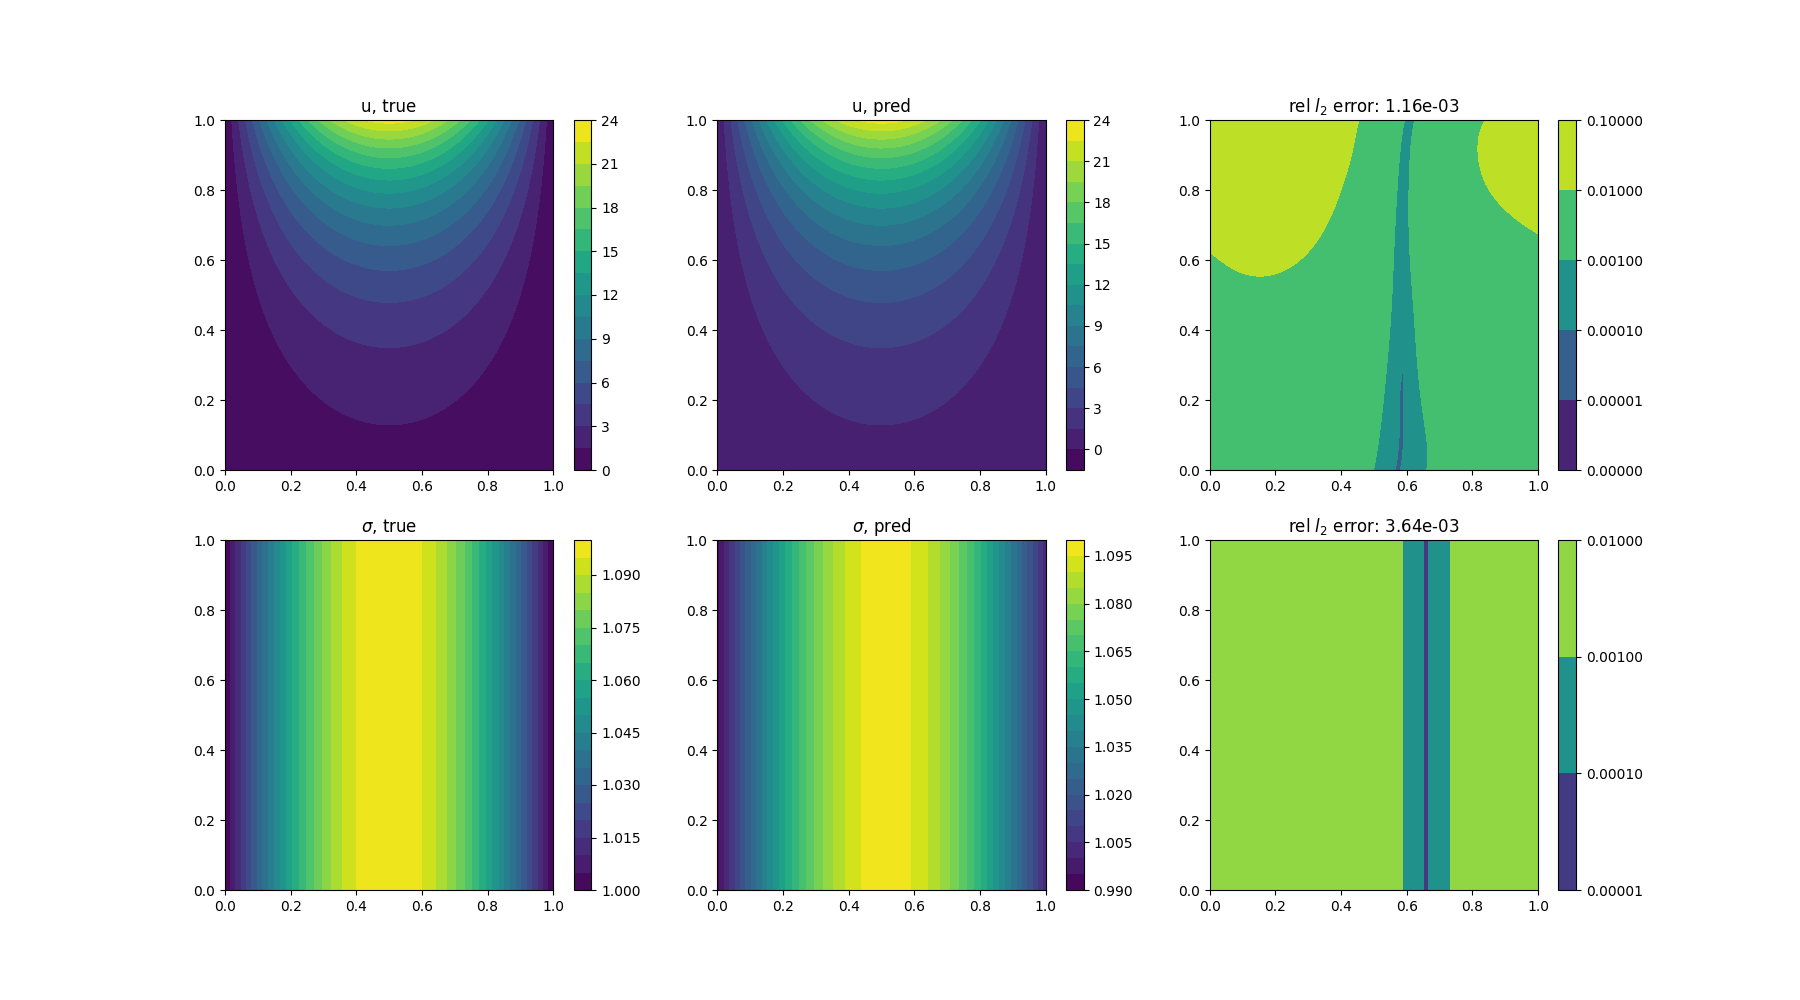

In [12]:
checkpoint_callback = trainer.callbacks[-1]
checkpoint = torch.load(checkpoint_callback.best_model_path)
pinn.load_state_dict(checkpoint["state_dict"])

x_test = torch.from_numpy(x_domain).to(pinn.device)
y_test = torch.from_numpy(y_domain).to(pinn.device)
u_test = u_fn(x_domain, y_domain).reshape((len(x_1d), len(y_1d))).T
# sigma_test = np.ones_like(u_test)
sigma_test = 1.0 + 0.1*np.sin(np.pi*x_domain).reshape((len(x_1d), len(y_1d))).T

with torch.no_grad():
	u_pred = pinn.forward(torch.hstack([x_test, y_test])).cpu().numpy().reshape((len(x_1d), len(y_1d))).T
	sigma_pred = pinn.inverse_module(torch.hstack([x_test, y_test])).cpu().numpy().reshape((len(x_1d), len(y_1d))).T
	
u_err = np.sqrt(np.mean((u_test - u_pred)**2))
u_norm = np.sqrt(np.mean(u_test**2))
sigma_err = np.sqrt(np.mean((sigma_test - sigma_pred)**2))
sigma_norm = np.sqrt(np.mean(sigma_test**2))

X, Y = np.meshgrid(x_1d, y_1d)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
cmap = mpl.cm.viridis
	
fig, axes = plt.subplots(2, 3, figsize = (18, 10))

c0 = axes[0][0].contourf(X, Y, u_test, cmap = cmap, levels = 20)
c1 = axes[0][1].contourf(X, Y, u_pred, cmap = cmap, levels = 20)
c2 = axes[0][2].contourf(X, Y, np.abs(u_test - u_pred), cmap = cmap, norm = mpl.colors.LogNorm())
c3 = axes[1][0].contourf(X, Y, sigma_test, cmap = cmap, levels = 20)
c4 = axes[1][1].contourf(X, Y, sigma_pred, cmap = cmap, levels = 20)
c5 = axes[1][2].contourf(X, Y, np.abs(sigma_test - sigma_pred), cmap = cmap, norm = mpl.colors.LogNorm())
 
for c, ax in zip([c0, c1, c2], axes[0]):
    fig.colorbar(c, ax = ax)

for ax, name in zip(axes[0], ["u, true", "u, pred", "rel $l_2$ error: {:.2e}".format(u_err/u_norm)]):
    ax.set_title(name)
	
for c, ax in zip([c3, c4, c5], axes[1]):
    fig.colorbar(c, ax = ax)

for ax, name in zip(axes[1], ["$\sigma$, true", "$\sigma$, pred", "rel $l_2$ error: {:.2e}".format(sigma_err/sigma_norm)]):
    ax.set_title(name)